# 4.2 Model Development for Public Buildings

<hr style="border:2px solid black">

# Outline <a id='index'></a>
1. [Introduction](#1)
1. [Model Development](#2)
    * [2.1 Define functions](#2.1)
    * [2.2 Gradient Boosting(GB)](#2.2)
    * [2.3 Extreme Gradient Boosting(XGBOOST)](#2.3)
    * [2.4 Random Forest(RF)](#2.4)
    * [2.5 Decision Tree(DT)](#2.5)
    * [2.6 Support Vector Machine(SVM)](#2.6)
    * [2.7 Deep Neural Network(DNN)](#2.7)
1. [Compare model performance using LBSM only](#3)
1. [Conclusion](#4)

<hr style="border:2px solid black">

# 1. Introduction [^](#index) <a name="1"></a> 

<div style="text-align: justify; text-indent: 2em; font-size: 16px;">
&nbsp;&nbsp;&nbsp;&nbsp;In this notebook, we have dedicated significant effort and expertise to develope six models to train our previous data.
The models are GB, XGBOOST, RF, DT, SVM and DNN. However, only the top 15 features from the rank of
feature importance are selected. For public buildings, the spatial features are more contributed to by LBSM features
as the spatial features from DEC are not as much as features from EPC. Moreover, 26 features out of 75 features are selected
as input for each model. Additional features such as Heating CO2 and Electricity CO2 are useful to study
the correlation of estimated energy consumption with CO2 emission for further analysis. Thus, these additional features
will be set as an index as they are not spatial or socioeconomic features.
Next, we evaluate the model's performance using R-squared,Mean Squared Error (MSE),Mean Absolute Error (MAE), and Root Mean Squared Error (RMSE). This evaluation is crucial as it allows us to compare the performance of the models and understand their predictive accuracy. 
Root Mean Squared Error (RMSE) to compare the model performance. Finally, the performance of the two datasets is compared.
The first dataset integrates DEC and LBSM datasets, while the other dataset only inputs from LBSM.
The input from LBSM is the nine features sorted by rank from feature importance.
<div>

In [2]:
import time
import numpy as np 
import pandas as pd
from scipy import stats
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [3]:
import os
import csv
import pickle
import tensorflow as tf
from absl import logging
from dataclasses import dataclass
logging.set_verbosity(logging.ERROR)
from tensorflow.keras import Sequential
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import  Dropout, Flatten, Input,Dense

2024-10-02 16:07:04.606028: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-02 16:07:05.461245: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
dom='/home/ffs223/Downloads/GHGs_coding/DOM_Main code/Job Portfolio/MRES_Project/3. PB_1723.csv'
df=pd.read_csv(dom)

df

,TOTAL_Energy(kwh/m2),LMK_KEY,POSTCODE,BUILDING_REFERENCE_NUMBER,CURRENT_OPERATIONAL_RATING,YR1_OPERATIONAL_RATING,YR2_OPERATIONAL_RATING,OPERATIONAL_RATING_BAND,ELECTRIC_CO2,HEATING_CO2,...,DOMINANT_ND_ACTIVITY_BY_C2_COUNT,DEC_COUNT,EPC_RATING_COUNT_DOM,EPC_RATING_COUNT_NONDOM,AGG_RVEPC_CURRENT_ENERGY_EFFICIENCY_BY_COUNT,AGG_RVEPC_CURRENT_ENERGY_RATING_BY_COUNT,COUNT_ND_UPRNS_bin,ESTIMATED_FLOOR_COUNT_bin,ESTIMATED_FLOOR_COUNT_binnumeric,COUNT_ND_binnumeric
0,206.0,18071,3730,4716,106.0,112.0,95.0,5,69.0,128.0,...,2,6,0,0,64.0,3,Greater than 150,41-50,9.0,6
1,167.0,18072,3730,4716,91.0,106.0,112.0,4,69.0,99.0,...,2,6,0,0,64.0,3,101-150,21-30,7.0,5
2,172.0,18070,3730,4716,95.0,95.0,95.0,4,86.0,97.0,...,2,6,0,0,64.0,3,Greater than 150,Greater than 50,10.0,6
3,203.0,18073,3730,4716,112.0,95.0,104.5,5,89.0,118.0,...,2,6,0,0,64.0,3,101-150,Greater than 50,10.0,5
4,162.0,7193,3730,69,88.0,91.0,106.0,4,61.0,99.0,...,2,6,0,0,64.0,3,101-150,Greater than 50,10.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23581,166.0,21689,442,3048,124.0,161.0,113.0,5,37.0,0.0,...,7,0,0,1,68.0,3,101-150,Greater than 50,10.0,5
23582,158.0,22497,981,3505,83.0,100.5,71.5,4,1521.0,462.0,...,2,0,0,0,69.0,2,Greater than 150,Greater than 50,10.0,6
23583,139.0,22994,970,3081,74.0,97.0,85.0,3,81.0,54.0,...,3,0,0,0,75.0,2,11-30,Greater than 50,10.0,2
23584,155.0,20851,970,3081,82.0,74.0,97.0,4,92.0,60.0,...,3,0,0,0,75.0,2,11-30,31-40,8.0,2


In [5]:
df.columns

Index(['TOTAL_Energy(kwh/m2)', 'LMK_KEY', 'POSTCODE',
       'BUILDING_REFERENCE_NUMBER', 'CURRENT_OPERATIONAL_RATING',
       'YR1_OPERATIONAL_RATING', 'YR2_OPERATIONAL_RATING',
       'OPERATIONAL_RATING_BAND', 'ELECTRIC_CO2', 'HEATING_CO2',
       'RENEWABLES_CO2', 'PROPERTY_TYPE', 'INSPECTION_DATE', 'LOCAL_AUTHORITY',
       'CONSTITUENCY', 'LODGEMENT_DATE', 'MAIN_BENCHMARK', 'MAIN_HEATING_FUEL',
       'TOTAL_FLOOR_AREA', 'ANNUAL_THERMAL_FUEL_USAGE',
       'TYPICAL_THERMAL_FUEL_USAGE', 'ANNUAL_ELECTRICAL_FUEL_USAGE',
       'TYPICAL_ELECTRICAL_FUEL_USAGE', 'RENEWABLES_FUEL_THERMAL',
       'RENEWABLES_ELECTRICAL', 'YR1_ELECTRICITY_CO2', 'YR2_ELECTRICITY_CO2',
       'YR1_HEATING_CO2', 'YR2_HEATING_CO2', 'YR1_RENEWABLES_CO2',
       'YR2_RENEWABLES_CO2', 'AIRCON_PRESENT', 'AC_INSPECTION_COMMISSIONED',
       'BUILDING_ENVIRONMENT', 'BUILDING_CATEGORY', 'ADDRESS',
       'LOCAL_AUTHORITY_LABEL', 'CONSTITUENCY_LABEL', 'POSTTOWN',
       'NOMINATED_DATE', 'OR_ASSESSMENT_END_DATE', 'L

In [6]:
df = df.dropna(subset=['MIX_CLASS'])

print(df['MIX_CLASS'].isnull().sum())

0


In [7]:
fi = [
   'TOTAL_Energy(kwh/m2)','PROPERTY_TYPE',
    'BUILDING_CATEGORY','SCU_FOOTPRINT',
    'TOTAL_FLOOR_AREA','ADDRESS',
    'MEAN_OBJECT_HEIGHT_M','OCCUPANCY_LEVEL',
    'LONGITUDE', 'EASTING','AIRCON_PRESENT',
    'OA','LATITUDE','OAC','NORTHING','WARD_CODE',
    
    'LSOA', 'MSOA','MAIN_HEATING_FUEL',
    'CONSTITUENCY','ADMINISTRATIVE_AREA',
    
  'UPRN','INSPECTION_DATE','HEATING_CO2', 'RENEWABLES_CO2', 'ELECTRIC_CO2',
  
]

dom_df = df[fi]
dom_df 

,TOTAL_Energy(kwh/m2),PROPERTY_TYPE,BUILDING_CATEGORY,SCU_FOOTPRINT,TOTAL_FLOOR_AREA,ADDRESS,MEAN_OBJECT_HEIGHT_M,OCCUPANCY_LEVEL,LONGITUDE,EASTING,...,LSOA,MSOA,MAIN_HEATING_FUEL,CONSTITUENCY,ADMINISTRATIVE_AREA,UPRN,INSPECTION_DATE,HEATING_CO2,RENEWABLES_CO2,ELECTRIC_CO2
0,206.0,240,192,1622.40,3811,455,6.67,1,-0.229347,522966.21,...,949,350,3,35,13,3.401835e+07,2019-03-07,128.0,0.0,69.0
1,167.0,240,192,1622.40,3811,455,6.67,1,-0.229347,522966.21,...,949,350,3,35,13,3.401835e+07,2020-03-04,99.0,0.0,69.0
2,172.0,240,192,1622.40,3811,455,6.67,0,-0.229347,522966.21,...,949,350,3,35,13,3.401835e+07,2017-03-22,97.0,0.0,86.0
3,203.0,240,192,1622.40,3811,455,6.67,1,-0.229347,522966.21,...,949,350,3,35,13,3.401835e+07,2018-02-28,118.0,0.0,89.0
4,162.0,240,192,1622.40,3811,454,6.67,1,-0.229347,522966.21,...,949,350,3,35,13,3.401835e+07,2021-03-04,99.0,0.0,61.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23581,166.0,215,29,661.42,410,5157,22.14,1,-0.077167,533517.00,...,2,0,2,15,6,9.550635e+07,2023-01-17,0.0,0.0,37.0
23582,158.0,24,263,4244.99,32550,1225,24.16,1,-0.101971,531796.00,...,2406,0,3,15,6,1.000229e+11,2023-08-03,462.0,0.0,1521.0
23583,139.0,240,192,1036.83,3077,6281,12.46,0,-0.077460,533502.00,...,2405,0,3,15,6,2.000001e+11,2023-01-23,54.0,0.0,81.0
23584,155.0,240,192,1036.83,3077,6281,12.46,0,-0.077460,533502.00,...,2405,0,3,15,6,2.000001e+11,2023-11-17,60.0,0.0,92.0


In [8]:
dom_df.loc[:,'INSPECTION_DATE'] = pd.to_datetime(dom_df['INSPECTION_DATE'])

In [9]:
dom_df.columns

Index(['TOTAL_Energy(kwh/m2)', 'PROPERTY_TYPE', 'BUILDING_CATEGORY',
       'SCU_FOOTPRINT', 'TOTAL_FLOOR_AREA', 'ADDRESS', 'MEAN_OBJECT_HEIGHT_M',
       'OCCUPANCY_LEVEL', 'LONGITUDE', 'EASTING', 'AIRCON_PRESENT', 'OA',
       'LATITUDE', 'OAC', 'NORTHING', 'WARD_CODE', 'LSOA', 'MSOA',
       'MAIN_HEATING_FUEL', 'CONSTITUENCY', 'ADMINISTRATIVE_AREA', 'UPRN',
       'INSPECTION_DATE', 'HEATING_CO2', 'RENEWABLES_CO2', 'ELECTRIC_CO2'],
      dtype='object')

In [10]:
#Rearrange the target variable (total_energy) to the first column
cols =dom_df.columns.tolist()
cols.insert(0, cols.pop(cols.index('TOTAL_Energy(kwh/m2)')))
dom_df= dom_df[cols]
dom_df

,TOTAL_Energy(kwh/m2),PROPERTY_TYPE,BUILDING_CATEGORY,SCU_FOOTPRINT,TOTAL_FLOOR_AREA,ADDRESS,MEAN_OBJECT_HEIGHT_M,OCCUPANCY_LEVEL,LONGITUDE,EASTING,...,LSOA,MSOA,MAIN_HEATING_FUEL,CONSTITUENCY,ADMINISTRATIVE_AREA,UPRN,INSPECTION_DATE,HEATING_CO2,RENEWABLES_CO2,ELECTRIC_CO2
0,206.0,240,192,1622.40,3811,455,6.67,1,-0.229347,522966.21,...,949,350,3,35,13,3.401835e+07,2019-03-07 00:00:00,128.0,0.0,69.0
1,167.0,240,192,1622.40,3811,455,6.67,1,-0.229347,522966.21,...,949,350,3,35,13,3.401835e+07,2020-03-04 00:00:00,99.0,0.0,69.0
2,172.0,240,192,1622.40,3811,455,6.67,0,-0.229347,522966.21,...,949,350,3,35,13,3.401835e+07,2017-03-22 00:00:00,97.0,0.0,86.0
3,203.0,240,192,1622.40,3811,455,6.67,1,-0.229347,522966.21,...,949,350,3,35,13,3.401835e+07,2018-02-28 00:00:00,118.0,0.0,89.0
4,162.0,240,192,1622.40,3811,454,6.67,1,-0.229347,522966.21,...,949,350,3,35,13,3.401835e+07,2021-03-04 00:00:00,99.0,0.0,61.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23581,166.0,215,29,661.42,410,5157,22.14,1,-0.077167,533517.00,...,2,0,2,15,6,9.550635e+07,2023-01-17 00:00:00,0.0,0.0,37.0
23582,158.0,24,263,4244.99,32550,1225,24.16,1,-0.101971,531796.00,...,2406,0,3,15,6,1.000229e+11,2023-08-03 00:00:00,462.0,0.0,1521.0
23583,139.0,240,192,1036.83,3077,6281,12.46,0,-0.077460,533502.00,...,2405,0,3,15,6,2.000001e+11,2023-01-23 00:00:00,54.0,0.0,81.0
23584,155.0,240,192,1036.83,3077,6281,12.46,0,-0.077460,533502.00,...,2405,0,3,15,6,2.000001e+11,2023-11-17 00:00:00,60.0,0.0,92.0


In [11]:
print(dom_df.shape)

(23586, 26)


In [12]:
dom_df.isnull().sum()

TOTAL_Energy(kwh/m2)    0
PROPERTY_TYPE           0
BUILDING_CATEGORY       0
SCU_FOOTPRINT           0
TOTAL_FLOOR_AREA        0
ADDRESS                 0
MEAN_OBJECT_HEIGHT_M    0
OCCUPANCY_LEVEL         0
LONGITUDE               0
EASTING                 0
AIRCON_PRESENT          0
OA                      0
LATITUDE                0
OAC                     0
NORTHING                0
WARD_CODE               0
LSOA                    0
MSOA                    0
MAIN_HEATING_FUEL       0
CONSTITUENCY            0
ADMINISTRATIVE_AREA     0
UPRN                    0
INSPECTION_DATE         0
HEATING_CO2             0
RENEWABLES_CO2          0
ELECTRIC_CO2            0
dtype: int64

In [13]:

#Apply groupby function to sum up the energy values by monthly
dom_df['INSPECTION_DATE'] = pd.to_datetime(dom_df['INSPECTION_DATE'])

dom_df['YearMonth'] = dom_df['INSPECTION_DATE'].dt.to_period('M')

dom_m = dom_df.groupby(['YearMonth',   
                        
  'PROPERTY_TYPE',
    'BUILDING_CATEGORY','SCU_FOOTPRINT',
    'TOTAL_FLOOR_AREA','ADDRESS',
    'MEAN_OBJECT_HEIGHT_M','OCCUPANCY_LEVEL',
    'LONGITUDE', 'EASTING','AIRCON_PRESENT',
    'OA','LATITUDE','OAC','NORTHING','WARD_CODE',
    
    'LSOA', 'MSOA','MAIN_HEATING_FUEL',
    'CONSTITUENCY','ADMINISTRATIVE_AREA',
    
  'UPRN','HEATING_CO2', 'RENEWABLES_CO2', 'ELECTRIC_CO2',

]).agg({
    'TOTAL_Energy(kwh/m2)': 'sum'
}).reset_index()


In [14]:
print(dom_m.shape)

(23520, 26)


In [15]:
#Ensure the true values of the target variable (Energy consumption) is the same before sum up and after sum up
before = dom_df['TOTAL_Energy(kwh/m2)'].sum()

after = dom_m['TOTAL_Energy(kwh/m2)'].sum()

print(f" Energy Consumption Before Grouping: {before}")
print(f" Energy Consumption After Grouping: {after}")


 Energy Consumption Before Grouping: 4948489.5
 Energy Consumption After Grouping: 4948489.5


In [16]:
# Check for duplicates after grouping
duplicates = dom_m.duplicated(subset=['YearMonth', 
                                      
  'TOTAL_Energy(kwh/m2)','PROPERTY_TYPE',
    'BUILDING_CATEGORY','SCU_FOOTPRINT',
    'TOTAL_FLOOR_AREA','ADDRESS',
    'MEAN_OBJECT_HEIGHT_M','OCCUPANCY_LEVEL',
    'LONGITUDE', 'EASTING','AIRCON_PRESENT',
    'OA','LATITUDE','OAC','NORTHING','WARD_CODE',
    
    'LSOA', 'MSOA','MAIN_HEATING_FUEL',
    'CONSTITUENCY','ADMINISTRATIVE_AREA',
    
  'UPRN','HEATING_CO2', 'RENEWABLES_CO2', 'ELECTRIC_CO2',
    ])

print("Any Duplicates ?:", duplicates.any())


Any Duplicates ?: False


In [ ]:
dom_m

In [18]:
#Set unnecessary features as index
dom_m.set_index(['YearMonth','UPRN','HEATING_CO2', 'RENEWABLES_CO2', 'ELECTRIC_CO2'], inplace=True)

In [19]:
dom_m

PROPERTY_TYPE  \
YearMonth UPRN         HEATING_CO2 RENEWABLES_CO2 ELECTRIC_CO2                  
2013-08   2.001177e+08 31.0        0.0            56.0                    240   
2013-10   5.084778e+06 117.0       0.0            375.0                   266   
2013-11   5.003461e+06 64.0        0.0            210.0                     8   
          1.000235e+11 432.0       0.0            312.0                   216   
2013-12   1.009184e+10 78.0        0.0            74.0                      8   
...                                                                       ...   
2023-12   2.000284e+08 42.0        0.0            56.0                    252   
          1.214150e+07 0.0         0.0            17.0                    266   
          6.154110e+06 174.0       0.0            353.0                   266   
          1.000230e+11 10.0        0.0            109.0                   266   
                       297.0       0.0            587.0                   266   

                                                                BUILDING_CATEGORY  \
YearMonth UPRN         HEATING_CO2 RENEWABLES_CO2 ELECTRIC_CO2                      
2013-08   2.001177e+08 31.0        0.0            56.0                        192   
2013-10   5.084778e+06 117.0       0.0            375.0                       210   
2013-11   5.003461e+06 64.0        0.0            210.0                       223   
          1.000235e+11 432.0       0.0            312.0                       237   
2013-12   1.009184e+10 78.0        0.0            74.0                        223   
...                                                                           ...   
2023-12   2.000284e+08 42.0        0.0            56.0                        199   
          1.214150e+07 0.0         0.0            17.0                        210   
          6.154110e+06 174.0       0.0            353.0                       210   
          1.000230e+11 10.0        0.0            109.0                       210   
                       297.0       0.0            587.0                       210   

                                                                SCU_FOOTPRINT  \
YearMonth UPRN         HEATING_CO2 RENEWABLES_CO2 ELECTRIC_CO2                  
2013-08   2.001177e+08 31.0        0.0            56.0                1671.69   
2013-10   5.084778e+06 117.0       0.0            375.0               2914.75   
2013-11   5.003461e+06 64.0        0.0            210.0               1249.92   
          1.000235e+11 432.0       0.0            312.0                506.01   
2013-12   1.009184e+10 78.0        0.0            74.0                 524.98   
...                                                                       ...   
2023-12   2.000284e+08 42.0        0.0            56.0                1929.52   
          1.214150e+07 0.0         0.0            17.0                 362.64   
          6.154110e+06 174.0       0.0            353.0               5790.48   
          1.000230e+11 10.0        0.0            109.0              10081.67   
                       297.0       0.0            587.0              10081.67   

                                                                TOTAL_FLOOR_AREA  \
YearMonth UPRN         HEATING_CO2 RENEWABLES_CO2 ELECTRIC_CO2                     
2013-08   2.001177e+08 31.0        0.0            56.0                      1533   
2013-10   5.084778e+06 117.0       0.0            375.0                     6521   
2013-11   5.003461e+06 64.0        0.0            210.0                     3069   
          1.000235e+11 432.0       0.0            312.0                     3475   
2013-12   1.009184e+10 78.0        0.0            74.0                      2029   
...                                                                          ...   
2023-12   2.000284e+08 42.0        0.0            56.0                      1682   
          1.214150e+07 0.0         0.0            17.0                       311   
          

In [20]:
dom_m.columns

Index(['PROPERTY_TYPE', 'BUILDING_CATEGORY', 'SCU_FOOTPRINT',
       'TOTAL_FLOOR_AREA', 'ADDRESS', 'MEAN_OBJECT_HEIGHT_M',
       'OCCUPANCY_LEVEL', 'LONGITUDE', 'EASTING', 'AIRCON_PRESENT', 'OA',
       'LATITUDE', 'OAC', 'NORTHING', 'WARD_CODE', 'LSOA', 'MSOA',
       'MAIN_HEATING_FUEL', 'CONSTITUENCY', 'ADMINISTRATIVE_AREA',
       'TOTAL_Energy(kwh/m2)'],
      dtype='object')

In [21]:
#Check for negative values from the target variable
neg_val = dom_df[dom_df['TOTAL_Energy(kwh/m2)'] < 0]
neg_val 

,TOTAL_Energy(kwh/m2),PROPERTY_TYPE,BUILDING_CATEGORY,SCU_FOOTPRINT,TOTAL_FLOOR_AREA,ADDRESS,MEAN_OBJECT_HEIGHT_M,OCCUPANCY_LEVEL,LONGITUDE,EASTING,...,MSOA,MAIN_HEATING_FUEL,CONSTITUENCY,ADMINISTRATIVE_AREA,UPRN,INSPECTION_DATE,HEATING_CO2,RENEWABLES_CO2,ELECTRIC_CO2,YearMonth


In [22]:
#Remove the negative values from the column
dom_df = dom_df[dom_df['TOTAL_Energy(kwh/m2)'] >= 0]
rubbish = dom_df[dom_df['TOTAL_Energy(kwh/m2)'] < 0]
rubbish

,TOTAL_Energy(kwh/m2),PROPERTY_TYPE,BUILDING_CATEGORY,SCU_FOOTPRINT,TOTAL_FLOOR_AREA,ADDRESS,MEAN_OBJECT_HEIGHT_M,OCCUPANCY_LEVEL,LONGITUDE,EASTING,...,MSOA,MAIN_HEATING_FUEL,CONSTITUENCY,ADMINISTRATIVE_AREA,UPRN,INSPECTION_DATE,HEATING_CO2,RENEWABLES_CO2,ELECTRIC_CO2,YearMonth


In [23]:
X = dom_m.drop(columns=['TOTAL_Energy(kwh/m2)'])
Y =dom_m['TOTAL_Energy(kwh/m2)']


In [24]:
#Split the dataset using the 80:20 ratio
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2,random_state=21)

In [25]:
X_train.shape

(18816, 20)

# 2. Model Development [^](#index) <a name="2"></a> 

###  2.1 Define function [^](#index) <a name="2.1"></a> 

<div style="text-align: justify; text-indent: 2em; font-size: 16px;">
&nbsp;&nbsp;&nbsp;&nbsp;After the dataset is separated into an 80:20 ratio, the data is normalized before being set as
input into the models. In this notebook, the StandardScaler function refers to z-score normalization.
The average mean and standard deviation for each feature are calculated.
The mean is subtracted from the original feature.
Then, the value is divided by the standard deviation of the feature to compute the standardized value.
This process applies to all features in X and the target variable (Y: Energy Consumption).
There are three functions defined before the models are developed.
Firstly, the model_eval function displays the metric values of R-squared, MAE, MSE, and RMSE. Secondly,
the plot_actual_vs_pred function will visualize a scatter plot of the actual energy consumption values versus the predicted energy consumption values. Finally, the time taken function determines the time to train a model after fitting the 
dataset. From this function, we can evaluate which models have the highest and lowest
computational efficiency.
<div>

In [27]:

# Initialize the StandardScaler for X and y
X_std = StandardScaler()
Y_std = StandardScaler()

# Fit the scaler on the entire data and transform
Xtrain_norm = X_std.fit_transform(X_train)
Xtest_norm = X_std.transform(X_test)
Ytrain_norm = Y_std.fit_transform(Y_train.values.reshape(-1, 1)).flatten()
Ytest_norm=Y_std.transform(Y_test.values.reshape(-1, 1)).flatten()
Xtrain_norm 


array([[ 0.51823365,  0.2308075 , -0.15250805, ...,  0.2262263 ,
         0.70050425,  0.73193705],
       [-2.85389761,  0.7437115 , -0.66798706, ...,  0.2262263 ,
         0.4140371 ,  1.03974224],
       [ 0.51823365,  0.2308075 , -0.07792743, ...,  0.2262263 ,
        -0.39761984, -0.60188543],
       ...,
       [-1.64748858, -0.79500049,  0.05482751, ...,  0.2262263 ,
         1.7031393 , -0.90969062],
       [ 0.51823365,  0.2308075 , -0.21805775, ...,  0.2262263 ,
        -0.15889721, -0.4992837 ],
       [ 0.89614491,  0.52862273,  0.05457295, ...,  0.2262263 ,
        -1.63897752,  1.65535262]])

In [28]:
Xtrain_norm.shape
Xtest_norm.shape
Ytrain_norm.shape
Ytest_norm.shape

(4704,)

In [29]:
Xtrain_norm.shape

(18816, 20)

In [30]:
Ytrain_norm.shape

(18816,)

In [31]:
Xtest_norm.shape

(4704, 20)

In [32]:
def model_eval(y_true, y_pred,result=True):
    """
    y_true: The actual values of energy consumption.
    y_pred: The predicted values of energy consumption.
    """
    
 
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)

    measured = {
        "R-squared": r2,
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse
    }
    return measured

In [33]:
def plot_actual_vs_pred(y_test, y_pred, model='Model', xlabel='Actual Values', ylabel='Predicted Values', scatter='green', line='blue', alpha=0.5):

    title = f'{model} Actual vs Predicted Values'
    
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, color=scatter, alpha=alpha)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color=line, linestyle='--')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()


In [34]:

def time_taken(model, Xtrain_norm, Ytrain_norm):
    """
    This function record the time taken for a model to train the training dataset.

    Parameters:
    model: The model to be trained.
    Xtrain_norm: The training features.
    Ytrain_norm: The training dataset for target variables.

    Returns:
    model: The trained model.
    tt: Time taken to train the model in seconds.
    """
    # Record the start time
    start = time.time()
    
    # Fit the model
    model.fit(Xtrain_norm, Ytrain_norm)
    
    # Record the end time
    end = time.time()
    
    # Calculate the time taken
    tt = end - start
    
    print(f"Time taken to train the model: {tt} seconds")
    
    return model,tt

###  2.2 Gradient Boosting(GB) [^](#index) <a name="2.2"></a> 

In [34]:

{'learning_rate': 0.2,
 'max_depth': 5,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 500}

{'learning_rate': 0.2,
 'max_depth': 5,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 500}

In [35]:
gbr=GradientBoostingRegressor(learning_rate= 0.2,
 max_depth= 5,
 min_samples_leaf=1,
 min_samples_split=3,
 n_estimators= 500)

gbr_t, gbr_tt = time_taken(gbr, Xtrain_norm, Ytrain_norm)

Time taken to train the model: 25.34951114654541 seconds


In [36]:
ypred=gbr.predict(Xtest_norm)
gb_result =model_eval(Ytest_norm, ypred,result=True)

# Print the results dictionary (optional)
print(gb_result)

{'R-squared': 0.6298725636914657, 'MAE': 0.3016043745157355, 'MSE': 0.44343838552095727, 'RMSE': 0.6659116949873739}


In [55]:
param_gridgb={
    
    'n_estimators':[10,50,100,500],
    'learning_rate':[0.1,0.2],
    'max_depth':[3,4,5],
    'min_samples_split':[2,3,4],
    'min_samples_leaf':[1,2,3],
 
}


In [57]:
from sklearn.model_selection import GridSearchCV
cross_val_score(gbr,Xtrain_norm,Ytrain_norm,cv=3,n_jobs=-1).mean()
gbr3_cv=GridSearchCV(estimator=gbr,param_grid=param_gridgb,
                    cv=3,n_jobs=-1,scoring='r2')
gbr3_cv.fit(Xtrain_norm,Ytrain_norm)
Ypred=gbr3_cv.predict(Xtest_norm)
gbr3_cv.best_params_

{'learning_rate': 0.2,
 'max_depth': 5,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 500}

In [37]:
dom_gb = dom_m.reset_index()

In [38]:
dom_gb.dropna(subset=['YearMonth','UPRN','HEATING_CO2', 'RENEWABLES_CO2', 'ELECTRIC_CO2'], inplace=True)


In [39]:
# Create multi_index for dom_gb including the additional columns
dom_gb['multi_index'] = list(zip(
    dom_gb['YearMonth'], 
    dom_gb['UPRN'], 
      dom_gb['HEATING_CO2'], 
    dom_gb['RENEWABLES_CO2'], 
    dom_gb['ELECTRIC_CO2'],
   
  
))

# Create multi_index for X_test including the additional columns
X_test['multi_index'] = list(zip(
    X_test.index.get_level_values(0),  # Assuming YearMonth
    X_test.index.get_level_values(1),  # Assuming UPRN
    X_test.index.get_level_values(2),  # Assuming HEATING_CO2
    X_test.index.get_level_values(3),  # Assuming RENEWABLES_CO2
    X_test.index.get_level_values(4)   # Assuming ELECTRIC_CO2
))

# Filtering dom_gb based on multi_index in X_test
energy_pred = dom_gb[dom_gb['multi_index'].isin(X_test['multi_index'])].copy()


In [40]:
energy_pred

,YearMonth,UPRN,HEATING_CO2,RENEWABLES_CO2,ELECTRIC_CO2,PROPERTY_TYPE,BUILDING_CATEGORY,SCU_FOOTPRINT,TOTAL_FLOOR_AREA,ADDRESS,...,OAC,NORTHING,WARD_CODE,LSOA,MSOA,MAIN_HEATING_FUEL,CONSTITUENCY,ADMINISTRATIVE_AREA,TOTAL_Energy(kwh/m2),multi_index
0,2013-08,2.001177e+08,31.0,0.0,56.0,240,192,1671.69,1533,5849,...,18,186140.36,301,76,59,3,31,1,171.0,"(2013-08, 200117731.0, 31.0, 0.0, 56.0)"
4,2013-12,1.009184e+10,78.0,0.0,74.0,8,223,524.98,2029,5493,...,20,178905.00,475,2366,926,3,15,7,264.0,"(2013-12, 10091843465.0, 78.0, 0.0, 74.0)"
7,2013-12,1.009282e+10,8124.0,0.0,18475.0,216,237,3313.70,147117,3878,...,5,181797.98,37,2136,828,3,4,30,513.0,"(2013-12, 10092817034.0, 8124.0, 0.0, 18475.0)"
11,2014-02,1.214114e+07,54.0,0.0,62.0,240,192,2273.70,2467,3795,...,9,179073.00,201,624,263,3,23,9,184.5,"(2014-02, 12141142.0, 54.0, 0.0, 62.0)"
19,2014-06,1.000230e+11,44.0,0.0,69.0,8,223,566.58,1699,5319,...,24,187037.00,127,1805,946,3,45,26,207.0,"(2014-06, 100023049461.0, 44.0, 0.0, 69.0)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23491,2023-12,1.009347e+10,0.0,0.0,320.0,240,192,2783.94,9345,920,...,5,183794.58,540,2450,685,2,70,25,62.0,"(2023-12, 10093474203.0, 0.0, 0.0, 320.0)"
23497,2023-12,2.071479e+08,6.0,0.0,27.0,240,192,3607.57,1313,534,...,30,197076.00,361,743,272,3,27,10,63.0,"(2023-12, 207147913.0, 6.0, 0.0, 27.0)"
23498,2023-12,2.071788e+08,138.0,0.0,90.0,240,192,3607.57,6703,1999,...,34,196661.37,361,738,271,3,27,10,130.0,"(2023-12, 207178764.0, 138.0, 0.0, 90.0)"
23499,2023-12,1.009051e+10,68.0,0.0,124.0,240,192,3829.19,4243,2237,...,24,188805.87,118,1775,721,3,44,26,136.0,"(2023-12, 10090505526.0, 68.0, 0.0, 124.0)"


In [41]:
print(X_test.index.names) 

['YearMonth', 'UPRN', 'HEATING_CO2', 'RENEWABLES_CO2', 'ELECTRIC_CO2']


In [42]:
X_test

,,,,,PROPERTY_TYPE,BUILDING_CATEGORY,SCU_FOOTPRINT,TOTAL_FLOOR_AREA,ADDRESS,MEAN_OBJECT_HEIGHT_M,OCCUPANCY_LEVEL,LONGITUDE,EASTING,AIRCON_PRESENT,...,LATITUDE,OAC,NORTHING,WARD_CODE,LSOA,MSOA,MAIN_HEATING_FUEL,CONSTITUENCY,ADMINISTRATIVE_AREA,multi_index
YearMonth,UPRN,HEATING_CO2,RENEWABLES_CO2,ELECTRIC_CO2,,,,,,,,,,,,,,,,,,,,,
2019-10,1.009342e+10,49.0,11.0,50.0,240,192,1860.39,2375,4574,8.58,1,-0.228497,523141.96,3,...,51.469215,30,175959.68,616,2297,875,3,58,32,"(2019-10, 10093416910.0, 49.0, 11.0, 50.0)"
2019-08,1.000229e+10,33.0,0.0,61.0,240,192,2259.76,3182,2264,4.69,1,-0.296279,518116.76,3,...,51.591790,27,189478.97,222,1050,421,3,37,15,"(2019-08, 10002293470.0, 33.0, 0.0, 61.0)"
2023-09,3.400652e+07,61.0,0.0,50.0,240,192,2013.25,1477,2118,3.45,0,-0.235470,522589.00,0,...,51.494835,14,178797.00,414,935,358,3,35,13,"(2023-09, 34006524.0, 61.0, 0.0, 50.0)"
2023-06,1.000233e+11,24.0,0.0,43.0,240,192,1702.65,1441,5694,3.81,1,-0.187236,526034.26,0,...,51.459533,19,174953.13,622,2242,881,3,1,32,"(2023-06, 100023326752.0, 24.0, 0.0, 43.0)"
2023-03,1.280025e+08,3.0,0.0,8.0,40,49,199.51,220,6563,8.19,0,-0.282255,519638.00,2,...,51.381080,27,166070.00,543,1408,578,3,49,21,"(2023-03, 128002519.0, 3.0, 0.0, 8.0)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06,2.000034e+11,85.0,0.0,102.0,8,223,1166.38,2090,3343,7.06,1,-0.075548,533749.00,2,...,51.474550,12,176821.00,92,1943,775,3,10,28,"(2023-06, 200003394795.0, 85.0, 0.0, 102.0)"
2017-02,1.000236e+11,45.0,0.0,75.0,8,223,264.72,1874,1499,6.33,1,-0.010063,537969.00,3,...,51.582835,23,188984.00,518,2220,856,3,69,31,"(2017-02, 100023584983.0, 45.0, 0.0, 75.0)"
2022-05,2.000034e+11,22.0,0.0,85.0,240,192,743.85,2795,4887,13.82,1,-0.092405,532518.00,0,...,51.495392,14,179108.00,80,1911,762,3,3,28,"(2022-05, 200003374339.0, 22.0, 0.0, 85.0)"


In [43]:
# Convert multi_index for comparison
energy_predn = set(energy_pred['multi_index'])
X_testn = set(X_test['multi_index'])

# Find extra rows in energy_pred that are not in X_test
extra_energypred = energy_predn - X_testn
print(f"Number of extra rows in energy_pred: {len(extra_energypred)}")

# Find missing rows in energy_pred that are present in X_test
missing_energypred = X_testn- energy_predn
print(f"Number of missing rows in energy_pred: {len(missing_energypred)}")


Number of extra rows in energy_pred: 0
Number of missing rows in energy_pred: 0


In [44]:
# Filter energy_pred to keep only rows that match with X_test
energy_predf= energy_pred[energy_pred['multi_index'].isin(X_test['multi_index'])]

# Check the lengths after filtering
print(f"Length of energy_pred filtered: {len(energy_predf)}")
print(f"Length of X_test: {len(X_test)}")


Length of energy_pred filtered: 4775
Length of X_test: 4704


In [45]:
# Check for duplicates in both DataFrames
print(f"Number of duplicate rows in energy_pred: {energy_pred.duplicated(subset='multi_index').sum()}")
print(f"Number of duplicate rows in X_test: {X_test.duplicated(subset='multi_index').sum()}")


Number of duplicate rows in energy_pred: 85
Number of duplicate rows in X_test: 14


In [46]:
# Remove duplicate rows in energy_pred based on multi_index
energy_predc = energy_pred.drop_duplicates(subset='multi_index')

# Check the new length
print(f"Length of energy_pred cleaned: {len(energy_predc)}")


Length of energy_pred cleaned: 4690


In [47]:
# Ensure energy_pred matches X_test in terms of row count (if needed)
energy_predm= energy_predc.head(len(X_test))
print(f"Length of energy_pred matched: {len(energy_predm)}")


Length of energy_pred matched: 4690


In [49]:
# Check the length of rfr_pred and X_testn
print(f"Length of rfr_pred before slicing: {len(ypred)}")
print(f"Length of X_testn: {len(X_testn)}")

# Ensure rfr_pred has enough predictions to match X_testn
if len(ypred) < len(X_testn):
    raise ValueError("ypred has fewer rows than X_testn.")


Length of rfr_pred before slicing: 4704
Length of X_testn: 4690


In [51]:
# Slice rfr_pred to match the length of X_testn
ypred = ypred[:len(X_testn)]

# Check if the lengths match
print(f"Length of rfr_pred after slicing: {len(ypred)}")
print(f"Length of X_testn: {len(X_testn)}")


Length of rfr_pred after slicing: 4690
Length of X_testn: 4690


In [53]:
energy_predm['Estimated Energy_gb (kwh/m2)'] = Y_std.inverse_transform(ypred.reshape(-1, 1)).flatten()

/tmp/ipykernel_7706/2140766185.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  energy_predm['Estimated Energy_gb (kwh/m2)'] = Y_std.inverse_transform(ypred.reshape(-1, 1)).flatten()


In [54]:
energy_predm.isnull().sum()

YearMonth                       0
UPRN                            0
HEATING_CO2                     0
RENEWABLES_CO2                  0
ELECTRIC_CO2                    0
PROPERTY_TYPE                   0
BUILDING_CATEGORY               0
SCU_FOOTPRINT                   0
TOTAL_FLOOR_AREA                0
ADDRESS                         0
MEAN_OBJECT_HEIGHT_M            0
OCCUPANCY_LEVEL                 0
LONGITUDE                       0
EASTING                         0
AIRCON_PRESENT                  0
OA                              0
LATITUDE                        0
OAC                             0
NORTHING                        0
WARD_CODE                       0
LSOA                            0
MSOA                            0
MAIN_HEATING_FUEL               0
CONSTITUENCY                    0
ADMINISTRATIVE_AREA             0
TOTAL_Energy(kwh/m2)            0
multi_index                     0
Estimated Energy_gb (kwh/m2)    0
dtype: int64

In [55]:
pb = [
   'UPRN', 'YearMonth', 
'TOTAL_Energy(kwh/m2)', 'Estimated Energy_gb (kwh/m2)','HEATING_CO2', 'RENEWABLES_CO2', 'ELECTRIC_CO2']
pb_pred = energy_predm[pb]
pb_pred

,UPRN,YearMonth,TOTAL_Energy(kwh/m2),Estimated Energy_gb (kwh/m2),HEATING_CO2,RENEWABLES_CO2,ELECTRIC_CO2
0,2.001177e+08,2013-08,171.0,159.475090,31.0,0.0,56.0
4,1.009184e+10,2013-12,264.0,137.967462,78.0,0.0,74.0
7,1.009282e+10,2013-12,513.0,236.147894,8124.0,0.0,18475.0
11,1.214114e+07,2014-02,184.5,165.371147,54.0,0.0,62.0
19,1.000230e+11,2014-06,207.0,263.514357,44.0,0.0,69.0
...,...,...,...,...,...,...,...
23491,1.009347e+10,2023-12,62.0,151.987789,0.0,0.0,320.0
23497,2.071479e+08,2023-12,63.0,198.247465,6.0,0.0,27.0
23498,2.071788e+08,2023-12,130.0,141.192219,138.0,0.0,90.0
23499,1.009051e+10,2023-12,136.0,142.193066,68.0,0.0,124.0


In [56]:
pb_pred.to_csv('4.2 PB_Energy Pred_GB.csv', index=False)

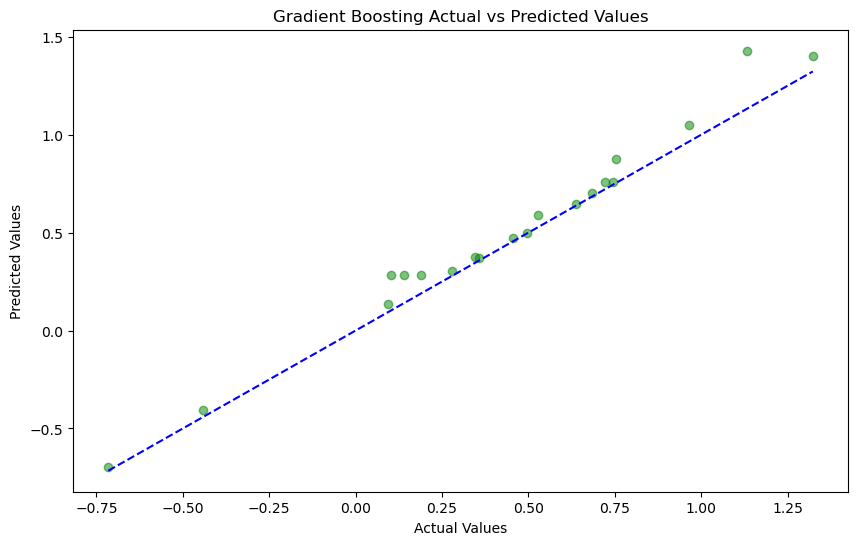

In [27]:
plot_actual_vs_pred(Ytest_norm, ypred, model='Gradient Boosting')

###  2.3 Extreme Gradient Boosting(XGBOOST) [^](#index) <a name="2.3"></a> 

In [ ]:
{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 500}

In [37]:
from xgboost import XGBRegressor

xgb=XGBRegressor(
  objective='reg:squarederror',
    learning_rate=0.1,
    max_depth=4,
    #min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    n_estimators=500,
    booster='gbtree',
    #use_label_encoder=False,
    ) 
xgb_train, xgb_tt = time_taken(xgb, Xtrain_norm, Ytrain_norm)


Time taken to train the model: 0.5427000522613525 seconds


In [38]:
pred=xgb.predict(Xtest_norm)
xgb_result =model_eval(Ytest_norm, pred,result=True)

print(xgb_result)

{'R-squared': 0.6266708065784952, 'MAE': 0.35526475727305384, 'MSE': 0.4472743130035728, 'RMSE': 0.6687857003581736}


In [48]:
param_XGB={
    
    'n_estimators':[10,50,100,500],
    'learning_rate':[0.1,0.2],
    'max_depth':[3,4,5],
   
    
}


In [49]:
cross_val_score(xgb,Xtrain_norm,Ytrain_norm,cv=10)

array([0.64496732, 0.47030639, 0.63528779, 0.44047598, 0.59993772,
       0.68936483, 0.6884348 , 0.64979075, 0.5998308 , 0.66158083])

In [50]:
cross_val_score(xgb,Xtrain_norm,Ytrain_norm,cv=2,n_jobs=-1).mean()
xgb_cv=GridSearchCV(estimator=xgb,param_grid=param_XGB,
                    cv=2,n_jobs=-1)
xgb_cv.fit(Xtrain_norm,Ytrain_norm)
pred1=xgb_cv.predict(Xtest_norm)
xgb_cv.best_params_

{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 500}

R-squared: 0.945
MAE: 0.077
MSE: 0.012
RMSE: 0.111


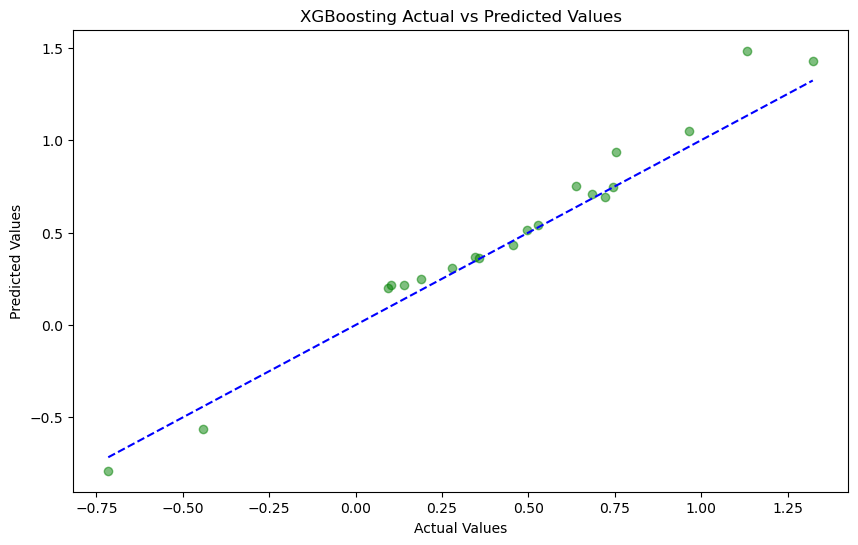

In [41]:
xgb_result =model_evaluation(Ytest_norm, pred,result=True)
plot_actual_vs_pred(Ytest_norm, pred, model='XGBoosting')

###  2.4 Random Forest(RF) [^](#index) <a name="2.4"></a> 

In [ ]:
{'criterion': 'squared_error',
 'max_features': 9,
 'min_samples_leaf': 3,
 'n_estimators': 500}

In [33]:
from sklearn.ensemble import RandomForestRegressor
rfr=RandomForestRegressor(
    bootstrap= True,
    criterion= 'squared_error',
 max_features= 9,
 min_samples_leaf= 3,
 n_estimators=500,
oob_score= True,
random_state=42,
verbose= 1,
 warm_start= False)
rf_train,rf_tt = time_taken(rfr, Xtrain_norm, Ytrain_norm)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   26.6s finished


Time taken to train the model: 27.31168484687805 seconds


In [34]:
rfr_pred=rfr.predict(Xtest_norm)
rfr_result =model_eval(Ytest_norm,rfr_pred,result=True)

print(rfr_result)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'R-squared': 0.6767718057370615, 'MAE': 0.296875666453545, 'MSE': 0.3872498349442325, 'RMSE': 0.6222940100500988}


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished


<div style="text-align: justify; text-indent: 2em; font-size: 16px;">
&nbsp;&nbsp;&nbsp;&nbsp;The following cells under the RF section are to get the estimated energy consumption
from RF and merge with additional features which previously set as an index into a data frame.Later, this dataframe
will be helpful for further analysis and comparison of estimated energy consumption between domestic and public buildings
using RF.<div>

In [35]:
dom_gb = dom_m.reset_index()

In [36]:
dom_gb.isnull().sum()

YearMonth               0
UPRN                    0
HEATING_CO2             0
RENEWABLES_CO2          0
ELECTRIC_CO2            0
PROPERTY_TYPE           0
BUILDING_CATEGORY       0
SCU_FOOTPRINT           0
TOTAL_FLOOR_AREA        0
ADDRESS                 0
MEAN_OBJECT_HEIGHT_M    0
OCCUPANCY_LEVEL         0
LONGITUDE               0
EASTING                 0
AIRCON_PRESENT          0
OA                      0
LATITUDE                0
OAC                     0
NORTHING                0
WARD_CODE               0
LSOA                    0
MSOA                    0
MAIN_HEATING_FUEL       0
CONSTITUENCY            0
ADMINISTRATIVE_AREA     0
TOTAL_Energy(kwh/m2)    0
dtype: int64

In [37]:
dom_gb

,YearMonth,UPRN,HEATING_CO2,RENEWABLES_CO2,ELECTRIC_CO2,PROPERTY_TYPE,BUILDING_CATEGORY,SCU_FOOTPRINT,TOTAL_FLOOR_AREA,ADDRESS,...,LATITUDE,OAC,NORTHING,WARD_CODE,LSOA,MSOA,MAIN_HEATING_FUEL,CONSTITUENCY,ADMINISTRATIVE_AREA,TOTAL_Energy(kwh/m2)
0,2013-08,2.001177e+08,31.0,0.0,56.0,240,192,1671.69,1533,5849,...,51.560499,18,186140.36,301,76,59,3,31,1,171.0
1,2013-10,5.084778e+06,117.0,0.0,375.0,266,210,2914.75,6521,1231,...,51.544328,11,184405.00,322,398,167,3,36,5,197.0
2,2013-11,5.003461e+06,64.0,0.0,210.0,8,223,1249.92,3069,6461,...,51.550319,12,185135.00,334,443,165,3,41,5,232.0
3,2013-11,1.000235e+11,432.0,0.0,312.0,216,237,506.01,3475,6943,...,51.517751,5,181580.00,12,2406,0,3,15,6,805.0
4,2013-12,1.009184e+10,78.0,0.0,74.0,8,223,524.98,2029,5493,...,51.494239,20,178905.00,475,2366,926,3,15,7,264.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23515,2023-12,2.000284e+08,42.0,0.0,56.0,252,199,1929.52,1682,5725,...,51.616704,28,192485.40,310,85,35,3,14,1,190.0
23516,2023-12,1.214150e+07,0.0,0.0,17.0,266,210,362.64,311,6784,...,51.504941,9,179808.00,192,586,256,2,21,9,97.0
23517,2023-12,6.154110e+06,174.0,0.0,353.0,266,210,5790.48,6050,67,...,51.500740,11,179846.00,19,2416,839,3,57,30,255.0
23518,2023-12,1.000230e+11,10.0,0.0,109.0,266,210,10081.67,4547,3592,...,51.591437,23,189940.00,499,2148,851,3,69,31,55.0


In [38]:
dom_gb.dropna(subset=['YearMonth','UPRN','HEATING_CO2', 'RENEWABLES_CO2', 'ELECTRIC_CO2'], inplace=True)


In [39]:
# Create multi_index for dom_gb 
dom_gb['multi_index'] = list(zip(
    dom_gb['YearMonth'], 
    dom_gb['UPRN'], 
      dom_gb['HEATING_CO2'], 
    dom_gb['RENEWABLES_CO2'], 
    dom_gb['ELECTRIC_CO2'],
   
  
))

# Create multi_index for X_test 
X_test['multi_index'] = list(zip(
    X_test.index.get_level_values(0),  # Assuming YearMonth
    X_test.index.get_level_values(1),  # Assuming UPRN
    X_test.index.get_level_values(2),  # Assuming HEATING_CO2
    X_test.index.get_level_values(3),  # Assuming RENEWABLES_CO2
    X_test.index.get_level_values(4)   # Assuming ELECTRIC_CO2
))

# Filtering dom_gb based on multi_index in X_test
energy_pred = dom_gb[dom_gb['multi_index'].isin(X_test['multi_index'])].copy()


In [40]:
energy_pred

,YearMonth,UPRN,HEATING_CO2,RENEWABLES_CO2,ELECTRIC_CO2,PROPERTY_TYPE,BUILDING_CATEGORY,SCU_FOOTPRINT,TOTAL_FLOOR_AREA,ADDRESS,...,OAC,NORTHING,WARD_CODE,LSOA,MSOA,MAIN_HEATING_FUEL,CONSTITUENCY,ADMINISTRATIVE_AREA,TOTAL_Energy(kwh/m2),multi_index
0,2013-08,2.001177e+08,31.0,0.0,56.0,240,192,1671.69,1533,5849,...,18,186140.36,301,76,59,3,31,1,171.0,"(2013-08, 200117731.0, 31.0, 0.0, 56.0)"
4,2013-12,1.009184e+10,78.0,0.0,74.0,8,223,524.98,2029,5493,...,20,178905.00,475,2366,926,3,15,7,264.0,"(2013-12, 10091843465.0, 78.0, 0.0, 74.0)"
7,2013-12,1.009282e+10,8124.0,0.0,18475.0,216,237,3313.70,147117,3878,...,5,181797.98,37,2136,828,3,4,30,513.0,"(2013-12, 10092817034.0, 8124.0, 0.0, 18475.0)"
11,2014-02,1.214114e+07,54.0,0.0,62.0,240,192,2273.70,2467,3795,...,9,179073.00,201,624,263,3,23,9,184.5,"(2014-02, 12141142.0, 54.0, 0.0, 62.0)"
19,2014-06,1.000230e+11,44.0,0.0,69.0,8,223,566.58,1699,5319,...,24,187037.00,127,1805,946,3,45,26,207.0,"(2014-06, 100023049461.0, 44.0, 0.0, 69.0)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23491,2023-12,1.009347e+10,0.0,0.0,320.0,240,192,2783.94,9345,920,...,5,183794.58,540,2450,685,2,70,25,62.0,"(2023-12, 10093474203.0, 0.0, 0.0, 320.0)"
23497,2023-12,2.071479e+08,6.0,0.0,27.0,240,192,3607.57,1313,534,...,30,197076.00,361,743,272,3,27,10,63.0,"(2023-12, 207147913.0, 6.0, 0.0, 27.0)"
23498,2023-12,2.071788e+08,138.0,0.0,90.0,240,192,3607.57,6703,1999,...,34,196661.37,361,738,271,3,27,10,130.0,"(2023-12, 207178764.0, 138.0, 0.0, 90.0)"
23499,2023-12,1.009051e+10,68.0,0.0,124.0,240,192,3829.19,4243,2237,...,24,188805.87,118,1775,721,3,44,26,136.0,"(2023-12, 10090505526.0, 68.0, 0.0, 124.0)"


In [41]:
print(X_test.index.names) 

['YearMonth', 'UPRN', 'HEATING_CO2', 'RENEWABLES_CO2', 'ELECTRIC_CO2']


In [42]:
X_test

,,,,,PROPERTY_TYPE,BUILDING_CATEGORY,SCU_FOOTPRINT,TOTAL_FLOOR_AREA,ADDRESS,MEAN_OBJECT_HEIGHT_M,OCCUPANCY_LEVEL,LONGITUDE,EASTING,AIRCON_PRESENT,...,LATITUDE,OAC,NORTHING,WARD_CODE,LSOA,MSOA,MAIN_HEATING_FUEL,CONSTITUENCY,ADMINISTRATIVE_AREA,multi_index
YearMonth,UPRN,HEATING_CO2,RENEWABLES_CO2,ELECTRIC_CO2,,,,,,,,,,,,,,,,,,,,,
2019-10,1.009342e+10,49.0,11.0,50.0,240,192,1860.39,2375,4574,8.58,1,-0.228497,523141.96,3,...,51.469215,30,175959.68,616,2297,875,3,58,32,"(2019-10, 10093416910.0, 49.0, 11.0, 50.0)"
2019-08,1.000229e+10,33.0,0.0,61.0,240,192,2259.76,3182,2264,4.69,1,-0.296279,518116.76,3,...,51.591790,27,189478.97,222,1050,421,3,37,15,"(2019-08, 10002293470.0, 33.0, 0.0, 61.0)"
2023-09,3.400652e+07,61.0,0.0,50.0,240,192,2013.25,1477,2118,3.45,0,-0.235470,522589.00,0,...,51.494835,14,178797.00,414,935,358,3,35,13,"(2023-09, 34006524.0, 61.0, 0.0, 50.0)"
2023-06,1.000233e+11,24.0,0.0,43.0,240,192,1702.65,1441,5694,3.81,1,-0.187236,526034.26,0,...,51.459533,19,174953.13,622,2242,881,3,1,32,"(2023-06, 100023326752.0, 24.0, 0.0, 43.0)"
2023-03,1.280025e+08,3.0,0.0,8.0,40,49,199.51,220,6563,8.19,0,-0.282255,519638.00,2,...,51.381080,27,166070.00,543,1408,578,3,49,21,"(2023-03, 128002519.0, 3.0, 0.0, 8.0)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06,2.000034e+11,85.0,0.0,102.0,8,223,1166.38,2090,3343,7.06,1,-0.075548,533749.00,2,...,51.474550,12,176821.00,92,1943,775,3,10,28,"(2023-06, 200003394795.0, 85.0, 0.0, 102.0)"
2017-02,1.000236e+11,45.0,0.0,75.0,8,223,264.72,1874,1499,6.33,1,-0.010063,537969.00,3,...,51.582835,23,188984.00,518,2220,856,3,69,31,"(2017-02, 100023584983.0, 45.0, 0.0, 75.0)"
2022-05,2.000034e+11,22.0,0.0,85.0,240,192,743.85,2795,4887,13.82,1,-0.092405,532518.00,0,...,51.495392,14,179108.00,80,1911,762,3,3,28,"(2022-05, 200003374339.0, 22.0, 0.0, 85.0)"


In [43]:
# Convert multi_index for comparison
energy_predn = set(energy_pred['multi_index'])
X_testn = set(X_test['multi_index'])

# Find extra rows in energy_pred that are not in X_test
extra_energypred = energy_predn - X_testn
print(f"Number of extra rows in energy_pred: {len(extra_energypred)}")

# Find missing rows in energy_pred that are present in X_test
missing_energypred = X_testn- energy_predn
print(f"Number of missing rows in energy_pred: {len(missing_energypred)}")


Number of extra rows in energy_pred: 0
Number of missing rows in energy_pred: 0


In [44]:
# Filter energy_pred to keep only rows that match with X_test
energy_predf= energy_pred[energy_pred['multi_index'].isin(X_test['multi_index'])]

# Check the lengths after filtering
print(f"Length of energy_pred filtered: {len(energy_predf)}")
print(f"Length of X_test: {len(X_test)}")


Length of energy_pred filtered: 4775
Length of X_test: 4704


In [45]:
# Check for duplicates in both DataFrames
print(f"Number of duplicate rows in energy_pred: {energy_pred.duplicated(subset='multi_index').sum()}")
print(f"Number of duplicate rows in X_test: {X_test.duplicated(subset='multi_index').sum()}")


Number of duplicate rows in energy_pred: 85
Number of duplicate rows in X_test: 14


In [46]:
# Remove duplicate rows in energy_pred based on multi_index
energy_predc = energy_pred.drop_duplicates(subset='multi_index')

# Check the new length
print(f"Length of energy_pred cleaned: {len(energy_predc)}")


Length of energy_pred_cleaned: 4690


In [47]:
# Ensure energy_pred matches X_test in terms of row count (if needed)
energy_predm= energy_predc.head(len(X_test))
print(f"Length of energy_pred matched: {len(energy_predm)}")


Length of energy_pred_matched: 4690


In [48]:
# Check the length of rfr_pred and X_testn
print(f"Length of rfr_pred before slicing: {len(rfr_pred)}")
print(f"Length of X_testn: {len(X_testn)}")

# Ensure rfr_pred has enough predictions to match X_testn
if len(rfr_pred) < len(X_testn):
    raise ValueError("rfr_pred has fewer rows than X_testn.")


Length of rfr_pred before slicing: 4704
Length of X_testn: 4690


In [49]:
# Slice rfr_pred to match the length of X_testn
rfr_pred = rfr_pred[:len(X_testn)]

# Check if the lengths match
print(f"Length of rfr_pred after slicing: {len(rfr_pred)}")
print(f"Length of X_testn: {len(X_testn)}")


Length of rfr_pred after slicing: 4690
Length of X_testn: 4690


In [50]:
if len(rfr_pred) == len(X_testn):
    print("rfr_pred and X_testn are aligned in length!")
else:
    print("There is still a length mismatch.")


rfr_pred and X_testn are aligned in length!


In [51]:
print(len(rfr_pred))
print(len(dom_gb))


4690
23520


In [52]:
# Check the lengths before slicing
print(len(rfr_pred))
print(len(X_testn))


4690
4690


In [53]:
energy_predm['Estimated Energy_rf (kwh/m2)'] = Y_std.inverse_transform(rfr_pred.reshape(-1, 1)).flatten()

/tmp/ipykernel_6530/4073724918.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  energy_predm['Estimated Energy_rf (kwh/m2)'] = Y_std.inverse_transform(rfr_pred.reshape(-1, 1)).flatten()


In [54]:
energy_predm

,YearMonth,UPRN,HEATING_CO2,RENEWABLES_CO2,ELECTRIC_CO2,PROPERTY_TYPE,BUILDING_CATEGORY,SCU_FOOTPRINT,TOTAL_FLOOR_AREA,ADDRESS,...,NORTHING,WARD_CODE,LSOA,MSOA,MAIN_HEATING_FUEL,CONSTITUENCY,ADMINISTRATIVE_AREA,TOTAL_Energy(kwh/m2),multi_index,Estimated Energy_rf (kwh/m2)
0,2013-08,2.001177e+08,31.0,0.0,56.0,240,192,1671.69,1533,5849,...,186140.36,301,76,59,3,31,1,171.0,"(2013-08, 200117731.0, 31.0, 0.0, 56.0)",131.898825
4,2013-12,1.009184e+10,78.0,0.0,74.0,8,223,524.98,2029,5493,...,178905.00,475,2366,926,3,15,7,264.0,"(2013-12, 10091843465.0, 78.0, 0.0, 74.0)",110.386215
7,2013-12,1.009282e+10,8124.0,0.0,18475.0,216,237,3313.70,147117,3878,...,181797.98,37,2136,828,3,4,30,513.0,"(2013-12, 10092817034.0, 8124.0, 0.0, 18475.0)",264.405802
11,2014-02,1.214114e+07,54.0,0.0,62.0,240,192,2273.70,2467,3795,...,179073.00,201,624,263,3,23,9,184.5,"(2014-02, 12141142.0, 54.0, 0.0, 62.0)",176.048003
19,2014-06,1.000230e+11,44.0,0.0,69.0,8,223,566.58,1699,5319,...,187037.00,127,1805,946,3,45,26,207.0,"(2014-06, 100023049461.0, 44.0, 0.0, 69.0)",273.363277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23491,2023-12,1.009347e+10,0.0,0.0,320.0,240,192,2783.94,9345,920,...,183794.58,540,2450,685,2,70,25,62.0,"(2023-12, 10093474203.0, 0.0, 0.0, 320.0)",137.693390
23497,2023-12,2.071479e+08,6.0,0.0,27.0,240,192,3607.57,1313,534,...,197076.00,361,743,272,3,27,10,63.0,"(2023-12, 207147913.0, 6.0, 0.0, 27.0)",184.058711
23498,2023-12,2.071788e+08,138.0,0.0,90.0,240,192,3607.57,6703,1999,...,196661.37,361,738,271,3,27,10,130.0,"(2023-12, 207178764.0, 138.0, 0.0, 90.0)",133.228405
23499,2023-12,1.009051e+10,68.0,0.0,124.0,240,192,3829.19,4243,2237,...,188805.87,118,1775,721,3,44,26,136.0,"(2023-12, 10090505526.0, 68.0, 0.0, 124.0)",139.495875


In [56]:
energy_predm.isnull().sum()

YearMonth                       0
UPRN                            0
HEATING_CO2                     0
RENEWABLES_CO2                  0
ELECTRIC_CO2                    0
PROPERTY_TYPE                   0
BUILDING_CATEGORY               0
SCU_FOOTPRINT                   0
TOTAL_FLOOR_AREA                0
ADDRESS                         0
MEAN_OBJECT_HEIGHT_M            0
OCCUPANCY_LEVEL                 0
LONGITUDE                       0
EASTING                         0
AIRCON_PRESENT                  0
OA                              0
LATITUDE                        0
OAC                             0
NORTHING                        0
WARD_CODE                       0
LSOA                            0
MSOA                            0
MAIN_HEATING_FUEL               0
CONSTITUENCY                    0
ADMINISTRATIVE_AREA             0
TOTAL_Energy(kwh/m2)            0
multi_index                     0
Estimated Energy_rf (kwh/m2)    0
dtype: int64

In [57]:
pb = [
   'UPRN', 'YearMonth', 
'TOTAL_Energy(kwh/m2)', 'Estimated Energy_rf (kwh/m2)','HEATING_CO2', 'RENEWABLES_CO2', 'ELECTRIC_CO2']
pb_pred = energy_predm[pb]
pb_pred

,UPRN,YearMonth,TOTAL_Energy(kwh/m2),Estimated Energy_rf (kwh/m2),HEATING_CO2,RENEWABLES_CO2,ELECTRIC_CO2
0,2.001177e+08,2013-08,171.0,131.898825,31.0,0.0,56.0
4,1.009184e+10,2013-12,264.0,110.386215,78.0,0.0,74.0
7,1.009282e+10,2013-12,513.0,264.405802,8124.0,0.0,18475.0
11,1.214114e+07,2014-02,184.5,176.048003,54.0,0.0,62.0
19,1.000230e+11,2014-06,207.0,273.363277,44.0,0.0,69.0
...,...,...,...,...,...,...,...
23491,1.009347e+10,2023-12,62.0,137.693390,0.0,0.0,320.0
23497,2.071479e+08,2023-12,63.0,184.058711,6.0,0.0,27.0
23498,2.071788e+08,2023-12,130.0,133.228405,138.0,0.0,90.0
23499,1.009051e+10,2023-12,136.0,139.495875,68.0,0.0,124.0


In [59]:
pb_pred.to_csv('4.2 PB_Energy Pred_RF.csv', index=False)

In [62]:
param_RF={
    'criterion':['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
    'n_estimators':[100,250,500],
    'max_features':[1,3,5,7,9],
    'min_samples_leaf':[3,5,15,25]
}

In [63]:
cross_val_score(rfr,Xtrain_norm,Ytrain_norm,cv=5)
rfr1= GridSearchCV(rfr,param_RF,cv=2,n_jobs=1) #TO FIND THE BEST PARAMS
rfr1.fit(Xtrain_norm,Ytrain_norm)
pred_rfr=rfr1.predict(Xtest_norm)
rfr1.best_params_

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    6.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    6.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    5.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    4.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    4.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    9.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    9.3s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    6.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    7.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   15.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   14.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   21.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   19.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:   50.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:   48.8s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  3.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  3.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   40.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  3.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  3.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  6.2min finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  6.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    4.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    8.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    8.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    4.8s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   12.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   11.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

{'criterion': 'squared_error',
 'max_features': 9,
 'min_samples_leaf': 3,
 'n_estimators': 500}

###  2.5 Decision Tree(DT) [^](#index) <a name="2.5"></a> 

In [75]:
{'criterion': 'squared_error',
 'max_features': 5,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'random_state': 52,
 'splitter': 'best'}

{'criterion': 'friedman_mse',
 'max_features': 9,
 'min_samples_leaf': 5,
 'min_samples_split': 15,
 'random_state': 52,
 'splitter': 'best'}

In [41]:

dt = DecisionTreeRegressor(criterion='squared_error',
                           splitter='best',
                            min_samples_split=2, 
                            min_samples_leaf=3,
                            max_features=5,  
                            random_state=52)


dtc_train, dtc_tt = time_taken(dt,Xtrain_norm, Ytrain_norm)


Time taken to train the model: 0.06067323684692383 seconds


In [42]:
dt_pred=dt.predict(Xtest_norm)
dt_result =model_eval(Ytest_norm,dt_pred,result=True)

print(dt_result)

{'R-squared': 0.5707856455569877, 'MAE': 0.3431985790059511, 'MSE': 0.5142286188640501, 'RMSE': 0.7170973566148813}


In [55]:
dtparam={
  'criterion':['squared_error', 'absolute_error', 'friedman_mse'],
    'splitter':['best', 'random'],
    'max_features':[1,3,5,7,9],
    'min_samples_leaf':[3,5,15,25],
        'min_samples_split':[2,5,15,25],
            'random_state':[21,42,52]
}

In [56]:

dt_cv=GridSearchCV(dt,dtparam,
                    cv=2,n_jobs=-1)
dt_cv.fit(Xtrain_norm, Ytrain_norm)
preddt=dt_cv.predict(Xtest_norm)
dt_cv.best_params_

{'criterion': 'squared_error',
 'max_features': 5,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'random_state': 52,
 'splitter': 'best'}

###  2.6 Support Vector Machine(SVM) [^](#index) <a name="2.6"></a> 

In [ ]:
C': 1, 'degree': 2, 'epsilon': 0.5, 'gamma': 'auto', 'kernel': 'rbf'

In [43]:

svr=SVR(
    kernel='rbf',degree=2,gamma='auto', 
     C=100, epsilon=0.5,
     max_iter=-1)

svr_train,svr_tt = time_taken(svr, Xtrain_norm, Ytrain_norm)


Time taken to train the model: 21.79458999633789 seconds


In [44]:
svr_pred=svr.predict(Xtest_norm)
svr_result =model_eval(Ytest_norm,svr_pred,result=True)

print(svr_result)

{'R-squared': 0.5735423383575129, 'MAE': 0.4168115142302658, 'MSE': 0.5109259093512566, 'RMSE': 0.714790815099954}


In [ ]:



param_svr = {
    'kernel': ['rbf', 'linear', 'poly'],
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'],
    'epsilon': [0.01, 0.1, 0.5, 1.0],
    'degree': [2, 3, 4]  # Only relevant for polynomial
}

svr = SVR()

gs_svr = GridSearchCV(estimator=svr, param_grid=param_svr, 
                           cv=5, n_jobs=-1, verbose=2)


gs_svr.fit(Xtrain_norm, Ytrain_norm)

# Get the best parameters
print("Best parameters: ",gs_svr.best_params_)
print("Best score: ", gs_svr.best_score_)


Fitting 5 folds for each of 288 candidates, totalling 1440 fits
[CV] END C=0.1, degree=2, epsilon=0.01, gamma=scale, kernel=poly; total time=   1.9s
[CV] END C=0.1, degree=2, epsilon=0.01, gamma=auto, kernel=rbf; total time=   2.3s
[CV] END C=0.1, degree=2, epsilon=0.1, gamma=scale, kernel=rbf; total time=   1.9s
[CV] END C=0.1, degree=2, epsilon=0.1, gamma=auto, kernel=rbf; total time=   1.7s
[CV] END C=0.1, degree=2, epsilon=0.1, gamma=auto, kernel=poly; total time=   1.3s
[CV] END C=0.1, degree=2, epsilon=0.5, gamma=scale, kernel=poly; total time=   0.8s
[CV] END C=0.1, degree=2, epsilon=0.5, gamma=auto, kernel=linear; total time=   1.2s
[CV] END C=0.1, degree=2, epsilon=1.0, gamma=scale, kernel=linear; total time=   0.6s
[CV] END C=0.1, degree=2, epsilon=1.0, gamma=auto, kernel=rbf; total time=   0.6s
[CV] END C=0.1, degree=3, epsilon=0.01, gamma=scale, kernel=rbf; total time=   4.2s
[CV] END C=0.1, degree=3, epsilon=0.01, gamma=auto, kernel=rbf; total time=   4.6s
[CV] END C=0.1, 

[CV] END C=0.1, degree=2, epsilon=0.01, gamma=scale, kernel=linear; total time=   2.0s
[CV] END C=0.1, degree=2, epsilon=0.01, gamma=auto, kernel=rbf; total time=   2.1s
[CV] END C=0.1, degree=2, epsilon=0.01, gamma=auto, kernel=poly; total time=   1.5s
[CV] END C=0.1, degree=2, epsilon=0.1, gamma=scale, kernel=linear; total time=   1.5s
[CV] END C=0.1, degree=2, epsilon=0.1, gamma=auto, kernel=linear; total time=   1.6s
[CV] END C=0.1, degree=2, epsilon=0.5, gamma=scale, kernel=rbf; total time=   0.5s
[CV] END C=0.1, degree=2, epsilon=0.5, gamma=scale, kernel=poly; total time=   0.6s
[CV] END C=0.1, degree=2, epsilon=0.5, gamma=auto, kernel=linear; total time=   1.1s
[CV] END C=0.1, degree=2, epsilon=1.0, gamma=scale, kernel=rbf; total time=   0.5s
[CV] END C=0.1, degree=2, epsilon=1.0, gamma=scale, kernel=linear; total time=   0.5s
[CV] END C=0.1, degree=2, epsilon=1.0, gamma=auto, kernel=rbf; total time=   0.4s
[CV] END C=0.1, degree=2, epsilon=1.0, gamma=auto, kernel=poly; total ti

[CV] END C=0.1, degree=2, epsilon=0.01, gamma=scale, kernel=linear; total time=   1.9s
[CV] END C=0.1, degree=2, epsilon=0.01, gamma=scale, kernel=poly; total time=   1.5s
[CV] END C=0.1, degree=2, epsilon=0.01, gamma=auto, kernel=linear; total time=   2.1s
[CV] END C=0.1, degree=2, epsilon=0.1, gamma=scale, kernel=linear; total time=   1.8s
[CV] END C=0.1, degree=2, epsilon=0.1, gamma=auto, kernel=linear; total time=   1.6s
[CV] END C=0.1, degree=2, epsilon=0.5, gamma=scale, kernel=linear; total time=   0.6s
[CV] END C=0.1, degree=2, epsilon=0.5, gamma=auto, kernel=rbf; total time=   1.3s
[CV] END C=0.1, degree=2, epsilon=1.0, gamma=scale, kernel=rbf; total time=   0.6s
[CV] END C=0.1, degree=2, epsilon=1.0, gamma=scale, kernel=poly; total time=   0.5s
[CV] END C=0.1, degree=2, epsilon=1.0, gamma=auto, kernel=linear; total time=   0.6s
[CV] END C=0.1, degree=3, epsilon=0.01, gamma=scale, kernel=linear; total time=   3.7s
[CV] END C=0.1, degree=3, epsilon=0.01, gamma=auto, kernel=rbf; 

[CV] END C=0.1, degree=2, epsilon=0.01, gamma=scale, kernel=rbf; total time=   2.5s
[CV] END C=0.1, degree=2, epsilon=0.01, gamma=auto, kernel=linear; total time=   2.4s
[CV] END C=0.1, degree=2, epsilon=0.1, gamma=scale, kernel=linear; total time=   1.6s
[CV] END C=0.1, degree=2, epsilon=0.1, gamma=auto, kernel=rbf; total time=   1.7s
[CV] END C=0.1, degree=2, epsilon=0.1, gamma=auto, kernel=poly; total time=   1.4s
[CV] END C=0.1, degree=2, epsilon=0.5, gamma=auto, kernel=rbf; total time=   1.2s
[CV] END C=0.1, degree=2, epsilon=1.0, gamma=scale, kernel=rbf; total time=   0.6s
[CV] END C=0.1, degree=2, epsilon=1.0, gamma=scale, kernel=linear; total time=   0.8s
[CV] END C=0.1, degree=2, epsilon=1.0, gamma=auto, kernel=poly; total time=   0.5s
[CV] END C=0.1, degree=3, epsilon=0.01, gamma=scale, kernel=linear; total time=   4.2s
[CV] END C=0.1, degree=3, epsilon=0.01, gamma=auto, kernel=rbf; total time=   4.4s
[CV] END C=0.1, degree=3, epsilon=0.1, gamma=scale, kernel=rbf; total time=

[CV] END C=0.1, degree=2, epsilon=0.01, gamma=scale, kernel=rbf; total time=   2.3s
[CV] END C=0.1, degree=2, epsilon=0.01, gamma=auto, kernel=linear; total time=   2.0s
[CV] END C=0.1, degree=2, epsilon=0.1, gamma=scale, kernel=rbf; total time=   1.9s
[CV] END C=0.1, degree=2, epsilon=0.1, gamma=scale, kernel=poly; total time=   1.4s
[CV] END C=0.1, degree=2, epsilon=0.1, gamma=auto, kernel=linear; total time=   1.7s
[CV] END C=0.1, degree=2, epsilon=0.5, gamma=scale, kernel=poly; total time=   0.6s
[CV] END C=0.1, degree=2, epsilon=0.5, gamma=auto, kernel=rbf; total time=   0.9s
[CV] END C=0.1, degree=2, epsilon=0.5, gamma=auto, kernel=poly; total time=   0.9s
[CV] END C=0.1, degree=2, epsilon=1.0, gamma=auto, kernel=rbf; total time=   0.5s
[CV] END C=0.1, degree=2, epsilon=1.0, gamma=auto, kernel=poly; total time=   0.4s
[CV] END C=0.1, degree=3, epsilon=0.01, gamma=scale, kernel=linear; total time=   3.8s
[CV] END C=0.1, degree=3, epsilon=0.01, gamma=auto, kernel=rbf; total time=  

[CV] END C=0.1, degree=2, epsilon=0.01, gamma=scale, kernel=linear; total time=   2.1s
[CV] END C=0.1, degree=2, epsilon=0.01, gamma=auto, kernel=rbf; total time=   2.1s
[CV] END C=0.1, degree=2, epsilon=0.1, gamma=scale, kernel=rbf; total time=   1.9s
[CV] END C=0.1, degree=2, epsilon=0.1, gamma=scale, kernel=poly; total time=   1.5s
[CV] END C=0.1, degree=2, epsilon=0.1, gamma=auto, kernel=poly; total time=   1.7s
[CV] END C=0.1, degree=2, epsilon=0.5, gamma=scale, kernel=poly; total time=   1.2s
[CV] END C=0.1, degree=2, epsilon=0.5, gamma=auto, kernel=poly; total time=   1.2s
[CV] END C=0.1, degree=2, epsilon=1.0, gamma=auto, kernel=rbf; total time=   0.6s
[CV] END C=0.1, degree=3, epsilon=0.01, gamma=scale, kernel=rbf; total time=   4.9s
[CV] END C=0.1, degree=3, epsilon=0.01, gamma=auto, kernel=linear; total time=   3.9s
[CV] END C=0.1, degree=3, epsilon=0.1, gamma=scale, kernel=rbf; total time=   3.8s
[CV] END C=0.1, degree=3, epsilon=0.1, gamma=auto, kernel=linear; total time= 

###  2.7  Deep Neural Network(DNN) [^](#index) <a name="2.7"></a> 

In [45]:
#Set a callback function using MAE metric
class tf_Callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('mae') is not None and logs.get('mae') < 0.01:#Set target for MAE =0.01
            print("\nReached MAE < 0.01, so cancelling training!")
            self.model.stop_training = True


In [46]:
#Define function to train the model
def fit(model, Xtrain_norm, Ytrain_norm, Xtest_norm, Ytest_norm, epochs, callbacks=None):
    """
    Trains the given model and calculates the time taken for training.

    Parameters:
        model : The model to be trained
        train_ds : The training dataset
        test_ds  : The test dataset
        epochs (int): Number of epochs for training
        callbacks: Stop from running after reach the target for MAE

    Returns:
        history: Training history
        tt (float): Time taken to train the model in minutes
    """
   
    # Start timing
    start_time = time.time()

    # Train the model
    history = model.fit(Xtrain_norm,Ytrain_norm,
                        epochs=epochs,
                        validation_data=(Xtest_norm,Ytest_norm),
                        callbacks=callbacks if callbacks else [])

    # End timing
    end_time = time.time()

    # Calculate the duration
    tt = (end_time - start_time)/60
    print(f'Time taken to run this model {model.__class__.__name__}: {tt:.2f} min')
    
    return history, tt


In [47]:
def loss_mae_hist(history):
    """
    Plot loss and MAE results for training and validation from history object.

    Parameter:
    history: It is an object in Keras library.
    """
    # Get the MAE and loss values from the training model using the history object
    mae = history.history['mae']
    val_mae = history.history['val_mae']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(mae))

    # Determine the maximum values for y axis
    max_mae = max(max(mae), max(val_mae))  # Get the max MAE
    max_loss = max(max(loss), max(val_loss))  # Get the max loss
    ylim = max(max_mae, max_loss)  # Check max_loss < max_mae
    yml = [0, ylim * 1.5]

    # Adjust the figure size
    plt.figure(figsize=(10, 12))  

    # Plotting for MAE values
    plt.subplot(2, 1, 1)  
    plt.plot(epochs, mae, 'r', label='Training MAE')
    plt.plot(epochs, val_mae, 'b', label='Validation MAE')
    plt.ylim(yml)
    plt.title('Training and Validation MAE', fontsize=16)  
    plt.xlabel('Epochs', fontsize=14)  
    plt.ylabel('MAE', fontsize=14)  
    plt.xticks(fontsize=12)  
    plt.yticks(fontsize=12)  
    plt.legend(fontsize=12)

    # Plotting for loss values
    plt.subplot(2, 1, 2)  
    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.ylim(yml)
    plt.title('Training and Validation Loss for Public Building ', fontsize=16) 
    plt.xlabel('Epochs', fontsize=14)  
    plt.ylabel('Loss', fontsize=14)  
    plt.xticks(fontsize=12)  
    plt.yticks(fontsize=12) 
    plt.legend(fontsize=12)

    plt.tight_layout()
    plt.show()


In [48]:


def eval_dnn(model, Xtest_norm, Ytest_norm, Y_std):

    Y_predn = model.predict(Xtest_norm)
    Y_pred = Y_std.inverse_transform(Y_predn.reshape(-1, 1)).flatten() # Unnormalize the predicted values
    
    # Unnormalize the Y_test data for comparison
    Y_test_ori = Y_std.inverse_transform(Ytest_norm.reshape(-1, 1)).flatten()
    r2 = r2_score(Y_test_ori, Y_pred)# Calculate the R²
    mse = mean_squared_error(Ytest_norm, Y_predn)
    rmse = np.sqrt(mse)
    # Print the R² Score
    print(f"R² Score : {r2}")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    
    return mse, rmse,r2, Y_pred, Y_test_ori  # Return R² score and unnormalized predictions



In [49]:
def Dnn():
    model = tf.keras.models.Sequential([
        
        tf.keras.Input(shape=(15,)),  # Input shape 15 features
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0005)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0005)),
        tf.keras.layers.Dense(1, activation='relu'),
    ])
    
    # Compile the model 
    model.compile(loss='mean_absolute_error', optimizer=Adam(learning_rate=0.0005), metrics=['mae'])
    
    return model

In [50]:
dnn = Dnn()
dnn_cb=tf_Callback()
hist_dnn, tt_dnn = fit(dnn, Xtrain_norm, Ytrain_norm, Xtest_norm, Ytest_norm, epochs=400,callbacks=dnn_cb)


Epoch 1/400
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6432 - mae: 0.6064 - val_loss: 0.6079 - val_mae: 0.5778
Epoch 2/400
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 966us/step - loss: 0.5895 - mae: 0.5610 - val_loss: 0.5987 - val_mae: 0.5745
Epoch 3/400
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 995us/step - loss: 0.5840 - mae: 0.5608 - val_loss: 0.5921 - val_mae: 0.5720
Epoch 4/400
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5742 - mae: 0.5549 - val_loss: 0.5860 - val_mae: 0.5687
Epoch 5/400
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 941us/step - loss: 0.5713 - mae: 0.5545 - val_loss: 0.5870 - val_mae: 0.5717
Epoch 6/400
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5629 - mae: 0.5480 - val_loss: 0.5808 - val_mae: 0.5669
Epoch 7/400
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5639 - mae: 0.5503 - val_loss: 0.5740 - val_mae: 0.5610
Epoch 8/400
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5462 - mae: 0.5334 - val_loss: 0.5673 - val_mae: 0.5548
Epoch 9/400
588/588 ━━━━━━━━━━━━━━━━━━━━ 1

Epoch 54/400
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4960 - mae: 0.4857 - val_loss: 0.5118 - val_mae: 0.5014
Epoch 55/400
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4978 - mae: 0.4875 - val_loss: 0.5144 - val_mae: 0.5042
Epoch 56/400
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 970us/step - loss: 0.4980 - mae: 0.4877 - val_loss: 0.5134 - val_mae: 0.5031
Epoch 57/400
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4951 - mae: 0.4848 - val_loss: 0.5141 - val_mae: 0.5037
Epoch 58/400
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4969 - mae: 0.4865 - val_loss: 0.5111 - val_mae: 0.5007
Epoch 59/400
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 957us/step - loss: 0.5014 - mae: 0.4909 - val_loss: 0.5102 - val_mae: 0.4998
Epoch 60/400
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4981 - mae: 0.4877 - val_loss: 0.5120 - val_mae: 0.5016
Epoch 61/400
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4904 - mae: 0.4800 - val_loss: 0.5128 - val_mae: 0.5023
Epoch 62/400
588/588 ━━━━━━━━━━━━━━━

Epoch 107/400
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4842 - mae: 0.4739 - val_loss: 0.5049 - val_mae: 0.4946
Epoch 108/400
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 974us/step - loss: 0.4865 - mae: 0.4762 - val_loss: 0.5039 - val_mae: 0.4936
Epoch 109/400
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 922us/step - loss: 0.4918 - mae: 0.4815 - val_loss: 0.5044 - val_mae: 0.4940
Epoch 110/400
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 980us/step - loss: 0.4842 - mae: 0.4739 - val_loss: 0.5043 - val_mae: 0.4940
Epoch 111/400
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 862us/step - loss: 0.4874 - mae: 0.4772 - val_loss: 0.5025 - val_mae: 0.4922
Epoch 112/400
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 964us/step - loss: 0.4804 - mae: 0.4702 - val_loss: 0.5027 - val_mae: 0.4924
Epoch 113/400
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 974us/step - loss: 0.4844 - mae: 0.4741 - val_loss: 0.5052 - val_mae: 0.4948
Epoch 114/400
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4848 - mae: 0.4744 - val_loss: 0.5049 - val_mae: 0.4946
Epoch 115/400
588/58

588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4698 - mae: 0.4590 - val_loss: 0.4992 - val_mae: 0.4883
Epoch 212/400
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 994us/step - loss: 0.4710 - mae: 0.4602 - val_loss: 0.4982 - val_mae: 0.4874
Epoch 213/400
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4762 - mae: 0.4653 - val_loss: 0.4943 - val_mae: 0.4834
Epoch 214/400
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 962us/step - loss: 0.4783 - mae: 0.4674 - val_loss: 0.4961 - val_mae: 0.4852
Epoch 215/400
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 842us/step - loss: 0.4798 - mae: 0.4690 - val_loss: 0.5009 - val_mae: 0.4901
Epoch 216/400
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4761 - mae: 0.4653 - val_loss: 0.4996 - val_mae: 0.4887
Epoch 217/400
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 844us/step - loss: 0.4796 - mae: 0.4688 - val_loss: 0.4969 - val_mae: 0.4861
Epoch 218/400
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 903us/step - loss: 0.4656 - mae: 0.4548 - val_loss: 0.4912 - val_mae: 0.4803
Epoch 219/400
588/588 ━━━━━━━━━━━━━━

588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 942us/step - loss: 0.4720 - mae: 0.4607 - val_loss: 0.4972 - val_mae: 0.4859
Epoch 316/400
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 960us/step - loss: 0.4635 - mae: 0.4522 - val_loss: 0.4947 - val_mae: 0.4834
Epoch 317/400
588/588 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step - loss: 0.4705 - mae: 0.4592 - val_loss: 0.4967 - val_mae: 0.4853
Epoch 318/400
588/588 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - loss: 0.4767 - mae: 0.4654 - val_loss: 0.4949 - val_mae: 0.4835
Epoch 319/400
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4763 - mae: 0.4649 - val_loss: 0.4927 - val_mae: 0.4813
Epoch 320/400
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 899us/step - loss: 0.4718 - mae: 0.4604 - val_loss: 0.4944 - val_mae: 0.4829
Epoch 321/400
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4598 - mae: 0.4484 - val_loss: 0.4971 - val_mae: 0.4857
Epoch 322/400
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 891us/step - loss: 0.4678 - mae: 0.4564 - val_loss: 0.4936 - val_mae: 0.4821
Epoch 323/400
588/588 ━━━━━━━━━━━━

In [51]:
mse, rmse,r2, Ypred_dnn, Ytest_dnn =eval_dnn(dnn, Xtest_norm, Ytest_norm, Y_std)

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step
R² Score : 0.47266786484795065
MSE: 0.6317805517042728
RMSE: 0.7948462440650222


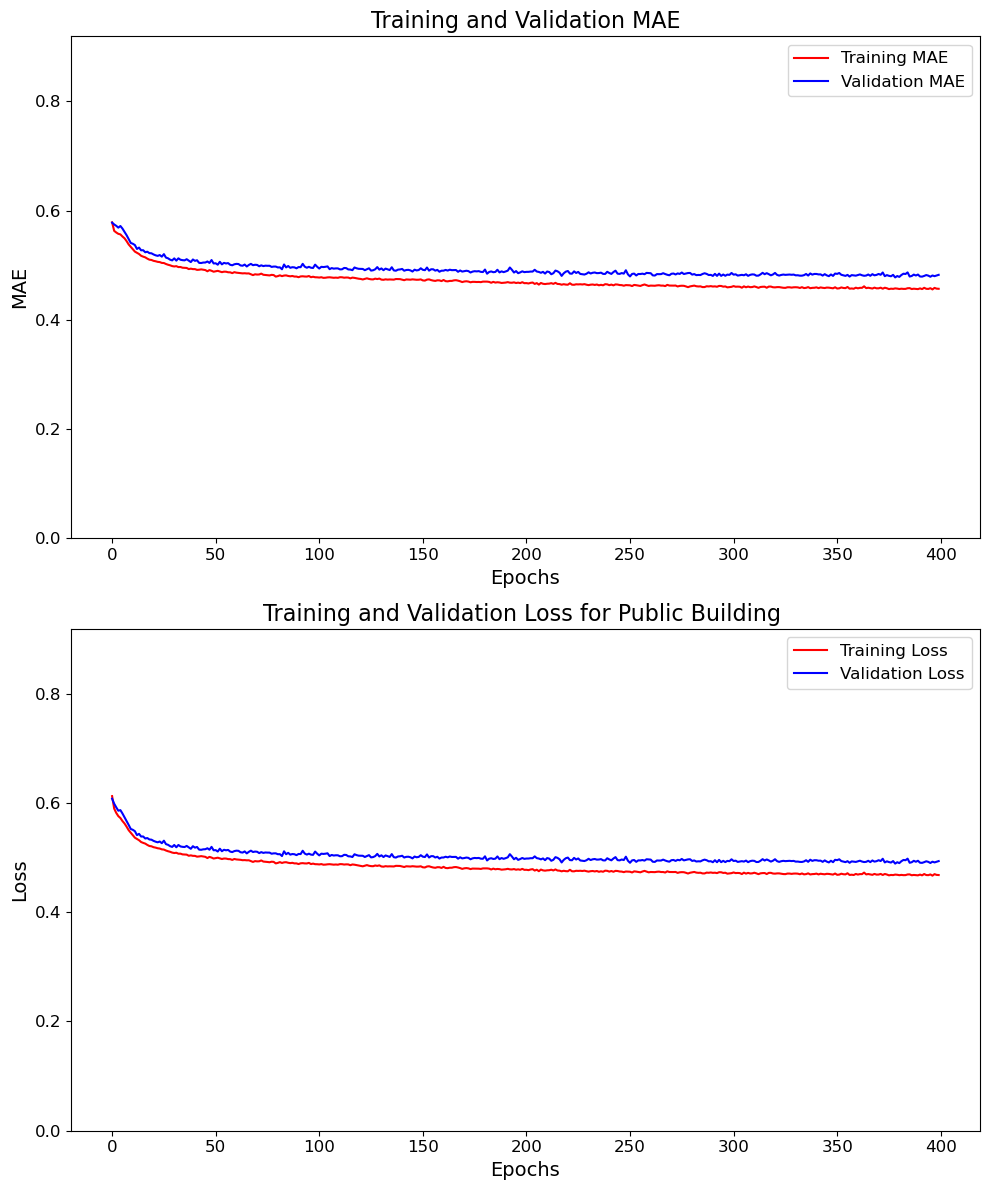

In [52]:
loss_mae_hist(hist_dnn)

<div style="text-align: justify; text-indent: 2em; font-size: 16px;">
&nbsp;&nbsp;&nbsp;&nbsp;The gap between the training and validation curves is relatively tiny based on the MAE and Loss plot of the training and validation dataset. It indicates that the model generalizes well to 
unseen data and does not overfit. The stabilization after a certain number of epochs between 200 and 250 epochs
illustrates that further training may not improve the model performance significantly. The time taken to fit the DNN
model for public buildings is shorter than that for domestic buildings. Due to
the lower number of neurons and the lower learning rate, the same optimizer and loss function are used, which
are Adam optimizer and mean absolute error as the loss function.<div>

# 3. Compare model performance using LBSM only [^](#index) <a id='3'></a>

<div style="text-align: justify; text-indent: 2em; font-size: 16px;">
&nbsp;&nbsp;&nbsp;&nbsp;This section selects nine features from LBSM, sorted by rank, as input.
The selected features are 'LATITUDE', 'LONGITUDE', 
 'NORTHING', 'OA',  'SCU_FOOTPRINT', 'MEAN_OBJECT_HEIGHT_M', 'OAC', 'EASTING' and 'WARD_CODE'.
Furthermore, from Section 2, RF appears to be the best model regarding R-squared, MAE, MSE, and RMSE. Therefore, RF is chosen 
for further analysis to compare two different datasets of DEC and LBSM and LBSM only. The pre-processed is
similar in section 2, yet the number of inputs is slightly different.<div>

In [28]:
fi = [
  'TOTAL_Energy(kwh/m2)',
   'UPRN','INSPECTION_DATE', 


    'LATITUDE', 'LONGITUDE', 
   'NORTHING','OA', 
    'SCU_FOOTPRINT','MEAN_OBJECT_HEIGHT_M',
    
    'OAC','EASTING','WARD_CODE', 
    
 'HEATING_CO2', 'RENEWABLES_CO2', 'ELECTRIC_CO2']
RF_lb = df[fi]
RF_lb

,TOTAL_Energy(kwh/m2),UPRN,INSPECTION_DATE,LATITUDE,LONGITUDE,NORTHING,OA,SCU_FOOTPRINT,MEAN_OBJECT_HEIGHT_M,OAC,EASTING,WARD_CODE,HEATING_CO2,RENEWABLES_CO2,ELECTRIC_CO2
0,206.0,3.401835e+07,2019-03-07,51.512597,-0.229347,180782.46,1212,1622.40,6.67,14,522966.21,420,128.0,0.0,69.0
1,167.0,3.401835e+07,2020-03-04,51.512597,-0.229347,180782.46,1212,1622.40,6.67,14,522966.21,420,99.0,0.0,69.0
2,172.0,3.401835e+07,2017-03-22,51.512597,-0.229347,180782.46,1212,1622.40,6.67,14,522966.21,420,97.0,0.0,86.0
3,203.0,3.401835e+07,2018-02-28,51.512597,-0.229347,180782.46,1212,1622.40,6.67,14,522966.21,420,118.0,0.0,89.0
4,162.0,3.401835e+07,2021-03-04,51.512597,-0.229347,180782.46,1212,1622.40,6.67,14,522966.21,420,99.0,0.0,61.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23581,166.0,9.550635e+07,2023-01-17,51.515484,-0.077167,181370.00,10,661.42,22.14,15,533517.00,13,0.0,0.0,37.0
23582,158.0,1.000229e+11,2023-08-03,51.515493,-0.101971,181326.00,6,4244.99,24.16,5,531796.00,11,462.0,0.0,1521.0
23583,139.0,2.000001e+11,2023-01-23,51.513664,-0.077460,181167.00,11,1036.83,12.46,11,533502.00,13,54.0,0.0,81.0
23584,155.0,2.000001e+11,2023-11-17,51.513664,-0.077460,181167.00,11,1036.83,12.46,11,533502.00,13,60.0,0.0,92.0


In [29]:
RF_lb.isnull().sum()

TOTAL_Energy(kwh/m2)    0
UPRN                    0
INSPECTION_DATE         0
LATITUDE                0
LONGITUDE               0
NORTHING                0
OA                      0
SCU_FOOTPRINT           0
MEAN_OBJECT_HEIGHT_M    0
OAC                     0
EASTING                 0
WARD_CODE               0
HEATING_CO2             0
RENEWABLES_CO2          0
ELECTRIC_CO2            0
dtype: int64

In [30]:
negative = RF_lb[RF_lb['TOTAL_Energy(kwh/m2)'] < 0]
rf_lb = RF_lb[RF_lb['TOTAL_Energy(kwh/m2)'] >= 0]
rubbish = RF_lb[RF_lb['TOTAL_Energy(kwh/m2)'] < 0]
rubbish

,TOTAL_Energy(kwh/m2),UPRN,INSPECTION_DATE,LATITUDE,LONGITUDE,NORTHING,OA,SCU_FOOTPRINT,MEAN_OBJECT_HEIGHT_M,OAC,EASTING,WARD_CODE,HEATING_CO2,RENEWABLES_CO2,ELECTRIC_CO2


In [31]:
RF_lb['INSPECTION_DATE'] = pd.to_datetime(RF_lb['INSPECTION_DATE'])
RF_lb['INSPECTION_DATE'].dtype

/tmp/ipykernel_32450/3402502260.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GB_lb['INSPECTION_DATE'] = pd.to_datetime(GB_lb['INSPECTION_DATE'])


dtype('<M8[ns]')

In [32]:
RF_lb.loc[:,'YearMonth'] = RF_lb['INSPECTION_DATE'].dt.to_period('M')

gb_m = RF_lb.groupby(['YearMonth',
 
    'LATITUDE', 'LONGITUDE', 
   'NORTHING','OA', 
    'SCU_FOOTPRINT','MEAN_OBJECT_HEIGHT_M',
    
    'OAC','EASTING','WARD_CODE', 
    
  'UPRN','HEATING_CO2', 'RENEWABLES_CO2', 'ELECTRIC_CO2',
  ]).agg({
    'TOTAL_Energy(kwh/m2)': 'sum'
}).reset_index()


/tmp/ipykernel_32450/2607922078.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GB_lb.loc[:,'YearMonth'] = GB_lb['INSPECTION_DATE'].dt.to_period('M')


In [14]:
before = RF_lb['TOTAL_Energy(kwh/m2)'].sum()

after =RF_lb['TOTAL_Energy(kwh/m2)'].sum()

print(f" Energy values Before Grouping: {before}")
print(f" Energy values  After Grouping: {after}")

 Energy values Before Grouping: 4948489.5
 Energy values  After Grouping: 4948489.5


In [33]:
gb_m.set_index(['UPRN','YearMonth','LATITUDE', 'LONGITUDE','HEATING_CO2', 'RENEWABLES_CO2', 'ELECTRIC_CO2'], inplace=True)

In [34]:
from sklearn.model_selection import train_test_split
x = gb_m.drop(columns=['TOTAL_Energy(kwh/m2)'])
y =gb_m['TOTAL_Energy(kwh/m2)']
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2,random_state=21)

In [35]:
# Initialize the StandardScaler for X and y
x_std = StandardScaler()
y_std = StandardScaler()

# Fit the scaler on the entire data and transform
Xtrain_norm = x_std.fit_transform(x_train)
Xtest_norm = x_std.transform( x_test)
Ytrain_norm = y_std.fit_transform(y_train.values.reshape(-1, 1)).flatten()
Ytest_norm=y_std.transform( y_test.values.reshape(-1, 1)).flatten()
Xtrain_norm 

array([[-1.33666381, -1.00831618, -0.48930985, ..., -0.23109594,
         0.21639091, -1.09548112],
       [ 0.0119183 ,  1.58149187, -0.59286761, ..., -1.01119516,
        -0.34327123,  0.55591257],
       [-0.23104736, -0.52930497, -0.50872076, ..., -0.67686692,
        -0.78037691,  0.27207928],
       ...,
       [-0.97246074,  0.37757047, -0.15534138, ...,  0.3261178 ,
         0.82972944,  0.16370657],
       [ 0.6174918 ,  0.50150355, -0.11655244, ...,  0.43756055,
         0.75825362,  0.90683373],
       [-0.70912524,  0.3451118 ,  3.82135844, ..., -0.67686692,
         0.62169865,  0.1895096 ]])

In [36]:
Xtrain_norm.shape
Xtest_norm.shape
Ytrain_norm.shape
Ytest_norm.shape

(4677,)

In [37]:
'learning_rate': 0.2,
 'max_depth': 5,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 500}

SyntaxError: unmatched '}' (1176233543.py, line 5)

In [38]:
from sklearn.ensemble import RandomForestRegressor
rfr=RandomForestRegressor(
    bootstrap= True,
    criterion= 'squared_error',
 max_features= 10,
 min_samples_leaf= 3,
 n_estimators=100,
oob_score= True,
random_state=42,
verbose= 1,
 warm_start= False)
rf_train,rf_tt = time_taken(rfr, Xtrain_norm, Ytrain_norm)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    9.1s finished


Time taken to train the model: 9.321967363357544 seconds


In [39]:
rfr_pred=rfr.predict(Xtest_norm)
rfr_result =model_eval(Ytest_norm,rfr_pred,result=True)

print(rfr_result)

{'R-squared': 0.6054280722386068, 'MAE': 0.3295985427786789, 'MSE': 0.3737943968984914, 'RMSE': 0.6113872724374392}


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


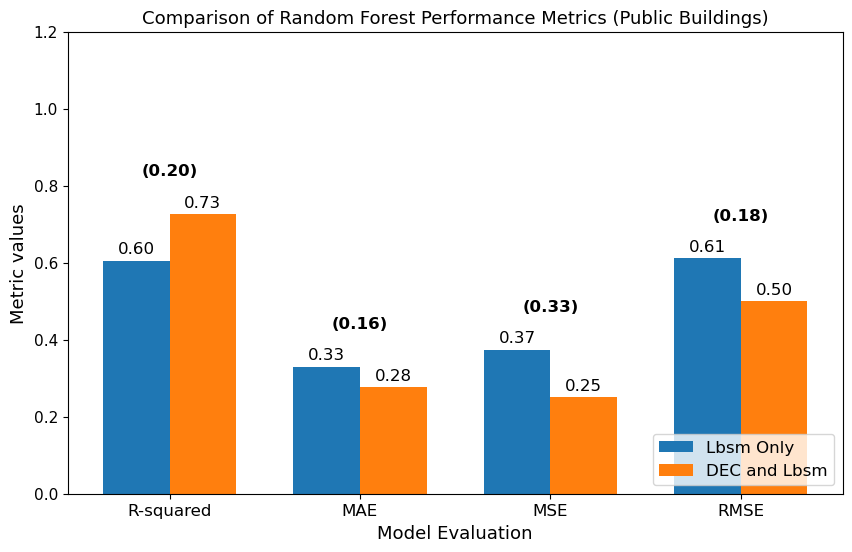

In [5]:


# Model evaluation from LBSM dataset only
#R-squared': 0.6054280722386068, 'MAE': 0.3295985427786789, 'MSE': 0.3737943968984914, 'RMSE': 0.6113872
rf_lbsm = {'R-squared': 0.605, 'MAE':  0.3295, 'MSE':  0.3737, 'RMSE': 0.611}


#R-squared': 0.7260006184316161, 'MAE': 0.27704791905441983, 'MSE': 0.2500476189196982, 'RMSE': 0.5000476166523526}
# Model evaluation from DEC & LBSM dataset
rf_dec = {'R-squared': 0.726, 'MAE': 0.277, 'MSE': 0.250, 'RMSE': 0.5000}

# Calculate % difference between each metric
percentage_diff = {metric: abs(rf_dec[metric] - rf_lbsm[metric]) / rf_lbsm[metric]  for metric in rf_dec}

# Prepare labels and values for plotting
labels = list(rf_dec.keys())
lbsm = list(rf_lbsm.values())
dec_lbsm = list(rf_dec.values())

# plot
x = np.arange(len(labels))  
width = 0.35  

fig, ax = plt.subplots(figsize=(10, 6))
b1 = ax.bar(x - width/2, lbsm, width, label='Lbsm Only')
b2 = ax.bar(x + width/2, dec_lbsm, width, label='DEC and Lbsm')
ax.set_xlabel('Model Evaluation', fontsize=13)
ax.set_ylabel('Metric values', fontsize=13)
ax.set_title('Comparison of Random Forest Performance Metrics (Public Buildings)', fontsize=13)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=12) 
ax.tick_params(axis='y', labelsize=11) 
ax.set_ylim([0, 1.2])

ax.legend(loc='lower right', fontsize=12)

# Function to add 
def label_new(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', fontsize=12,va='bottom')

label_new(b1)
label_new(b2)

# Calc % diff
for i, label in enumerate(labels):
    ax.text(x[i], max(lbsm[i], dec_lbsm[i]) + 0.1, f'({percentage_diff[label]:.2f})', 
            ha='center', fontsize=12, color='black',fontweight='bold')

plt.show()



<div style="text-align: justify; text-indent: 2em; font-size: 16px;">
&nbsp;&nbsp;&nbsp;&nbsp;Based on the figure above illustrates metrics comparison with the different datasets 
for (Public buildings) which have lower metric differences for all model evaluations, where the highest metric
difference is on MSE with a value of 0.33. One of the reasons is that the input for the blue bar is nine LBSM
features out of 15 features from the integration of the DEC and LBSM datasets. On the other hand, the metric
difference in LBSM features only for domestic buildings is relatively high.
It explains that a higher number of features can reduce the metric difference 
between the two different datasets.<div>

# 4. Conclusion [^](#index) <a id='4'></a>

<div style="text-align: justify; text-indent: 2em; font-size: 16px;">
&nbsp;&nbsp;&nbsp;&nbsp;Based on the six models developed, RF is the best model, with the highest score
for R-squared and the lowest value for MAE, MSE and RMSE.On the other hand, DT takes the shortest time to fit the model, followed by XGBoost. The R-squared for XGBoost and GB are similar, at 0.63. However, XGBoost is more
computationally efficient than GB due to improvements in the XGBoost algorithm.
It makes XGBoost handle NAN values better and avoids overfitting compared to GB.DNN has the highest time to fit the model as it is trained for 400 epochs
to investigate how well it generalizes the unseen data. The lower number of neurons and lower value of the learning rate
are used in the model architecture to improve the model's performance. Moreover, the activation function used at the last
layer is relu instead of sigmoid, as the model performs very well with the relu activation function. In addition, the 
estimated energy consumption from RF is saved in another file for further analysis to compare the estimated
energy consumption with that of domestic buildings. The overall R-squared values for all models are quite low
compared to the model's performance for domestic buildings. This is due to less detailed spatial features
of public buildings from DEC compared to EPC. Finally, the last section compares the two datasets. The 
metric difference between the two datasets is due to more LBSM features sorted in a rank of feature
importance. Since LBSM has more spatial features than DEC, nine out of fifteen features are
from LBSM.<div>